In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import MDAnalysis as mda
import seaborn as sns
from seaborn import kdeplot
from pylab import cm
from tqdm import tqdm

In [2]:
import pandas as pd
import os,sys

In [3]:
#######PLOTTING PARAMS########
plt.rcParams['figure.dpi'] = 100
#plt.figure(figsize=(10, 8))
plt.rc("axes",linewidth=2)
plt.rc("legend",fontsize=10,frameon=False)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = "serif"
tdir = 'in'
major = 5.0
minor = 3.0
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
#plt.savefig('my_plot.png', dpi=400)  # Save with DPI of 400

In [4]:
label = np.array(['HIA', 'OB', 'p-gp inhibitor', 'p-gp substrates', 'BBB',
       'Respiratory toxicity', 'Hepatotoxicity', 'half-life', 'CL',
       'Cardiotoxicity1', 'Cardiotoxicity10', 'Cardiotoxicity30',
       'Cardiotoxicity5', 'CYP1A2', 'CYP2C19', 'CYP2C9', 'CYP2D6', 'CYP3A4',
       'Acute oral toxicity (LD50)', 'IGC50', 'ESOL', 'logD',
       'Caco-2 permeability', 'PPB'])
binary = np.array([True]*18 + [False]*6)

In [5]:
data = np.loadtxt("seq2seq_data.dat", delimiter = " ")
RS = 23

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
features = data[:,-24:]
m = StandardScaler()
m.fit(features[:,~binary])
features[:,-6:] = m.transform(features[:,~binary])
data[:,-24:] = features

In [7]:

from sklearn.model_selection import train_test_split
# Step 1: Split into 80% training and 20% temporary set
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=RS)

# Step 2: Split the temporary set into 50% validation and 50% testing (each will be 10% of the original data)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RS)

In [19]:
train_df[0].shape

(536,)

In [8]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

36126
4516
4516


In [9]:
train_data = train_df[:,:-24]
val_data = val_df[:,:-24]
test_data = test_df[:,:-24]
train_label = train_df[:,-24:]
val_label = val_df[:,-24:]
test_label = test_df[:,-24:]

In [10]:
print(train_label.shape)

(36126, 24)


In [11]:
i=21
train_label[:,i][~np.isnan(train_label[:,i])].shape

(845,)

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import random
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, r2_score
from joblib import Parallel, delayed
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau,CosineAnnealingLR

class MultiTaskModel4(nn.Module):
    """
    A PyTorch-based Multi-Task Learning model that allows for shared layers across tasks and dedicated layers for each task.
    The model supports both binary classification and regression tasks and uses different loss functions accordingly.
    """

    def __init__(self, input_size, train_data, val_data, train_label, val_label,
                 epochs, batch_size, shared_str, dedicated_str, ntasks, binary,
                 label, benchmark = None, k=1, thresh=0.0001, duplicate=True, dropout_rate=0.3):
        """
        Initializes the MultiTaskModel4.

        Parameters:
        - input_size (int): The size of the input feature vector.
        - train_data (torch.Tensor): The training data features.
        - val_data (torch.Tensor): The validation data features.
        - test_data (torch.Tensor): The testing data features.
        - train_label (torch.Tensor): The training data labels.
        - val_label (torch.Tensor): The validation data labels.
        - test_label (torch.Tensor): The testing data labels.
        - epochs (int): The number of epochs to train the model.
        - batch_size (int): The size of each batch for training.
        - shared_str (list[int]): The structure (number of units) of the shared layers.
        - dedicated_str (list[int] or list[list[int]]): The structure (number of units) of the dedicated layers for each task. If `duplicate` is True, this should be a single list.
        - ntasks (int): The number of tasks.
        - binary (list[bool]): A list indicating whether each task is a binary classification (`True`) or a regression (`False`).
        - k (float): The parameter for the inverse quadratic switching function.
        - thresh (float): The threshold for early stopping (not used in this implementation).
        - duplicate (bool): If `True`, use the same `dedicated_str` structure for all tasks; otherwise, each task has its own dedicated structure.
        - dropout_rate (float): The dropout rate for regularization.
        """
        super(MultiTaskModel4, self).__init__()

        # Validation checks
        if ntasks < 1:
            raise ValueError("Number of tasks must be at least 1.")
        if not duplicate and len(dedicated_str) != ntasks:
            raise ValueError("Length of `dedicated_str` must match `ntasks` when `duplicate` is False.")

        # Initialize parameters
        self.epochs = epochs
        self.batch_size = batch_size
        self.ntasks = ntasks
        self.thresh = thresh
        self.k = k
        self.binary = binary
        self.label = label
        self.benchmark = benchmark

        torch.manual_seed(1)
        np.random.seed(1)
        # Shared layers
        self.shared_layers = nn.Sequential()
        for i, units in enumerate(shared_str):
            self.shared_layers.add_module(f'linear_{i}', nn.Linear(input_size, units))
            self.shared_layers.add_module(f'relu_{i}', nn.LeakyReLU())
            self.shared_layers.add_module(f'dropout_{i}', nn.Dropout(dropout_rate))
            input_size = units

        # Dedicated layers for each task
        self.task_layers = nn.ModuleList()
        for i in range(ntasks):
            task = nn.Sequential()
            hidden_size = input_size

            if duplicate:
                task_str = dedicated_str
            else:
                task_str = dedicated_str[i]

            for j, units in enumerate(task_str):
                task.add_module(f'linear_block{i}_{j}', nn.Linear(hidden_size, units))
                task.add_module(f'relu_block{i}_{j}', nn.LeakyReLU())
                task.add_module(f'dropout_block{i}_{j}', nn.Dropout(dropout_rate))
                hidden_size = units

            task.add_module(f'output_{i}', nn.Linear(hidden_size, 1))
            self.task_layers.append(task)


        # Prepare datasets and dataloaders
        self.train_dataset = TensorDataset(train_data, train_label)
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_dataset = TensorDataset(val_data, val_label)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

        # Define loss functions
        self.mse_loss = nn.MSELoss(reduction='sum')
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='sum')

        # Initialize optimizer with task-specific learning rates
        param_groups = [{'params': self.shared_layers.parameters(), 'lr': 0.001}]  # Shared layers
        for i, task in enumerate(self.task_layers):
            valid_labels = np.where(~torch.isnan(train_label[:, i]))[0]  # Handling NaN values
            valid_ratio = len(valid_labels) / len(train_label)
            task_lr = 0.001 * self.switching_function(valid_ratio) # Task-specific learning rates
            print(i,len(valid_labels),task_lr)
            param_groups.append({'params': task.parameters(), 'lr': task_lr})

        self.optimizer = optim.AdamW(param_groups, weight_decay=1e-4)

        # Initialize separate schedulers for each task
        #self.schedulers = [
        #    ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=5, verbose=True, cooldown=0, threshold=1e-4)
        #    for _ in range(24)
        #]

        # Initialize separate CosineAnnealingLR schedulers for each task
        self.schedulers = [
            CosineAnnealingLR(self.optimizer, T_max=self.epochs, eta_min=1e-6)  # T_max is the max number of iterations/epochs for annealing
            for _ in range(len(self.task_layers))
        ]
    def switching_function(self, x):
        """
        Logarithmic switching function.

        Parameters:
        - x (float): The number of valid labels for the task.

        Returns:
        - float: The scaling factor for the learning rate.
        """
        return 1 + np.log(1 + self.k*x)

    '''
    def switching_function(self, x):
        """
        Modified inverse quadratic switching function.

        Parameters:
        - x (float): The number of valid labels for the task.

        Returns:
        - float: The scaling factor for the learning rate.
        """
        return 1 + self.k * (x + 1)**2
    '''
    def compute_auc(self, y_true, y_pred):
        """
        Compute AUC score.

        Parameters:
        - y_true (torch.Tensor): True labels.
        - y_pred (torch.Tensor): Predicted scores.

        Returns:
        - float: AUC score.
        """
        y_true = y_true
        y_pred = y_pred
        if len(np.unique(y_true)) == 1:
            # Only one class present, AUC is undefined
            return 0.5  # 0.5 for random
        return roc_auc_score(y_true, y_pred)


    def compute_r2(self, y_true, y_pred):
        """
        Compute R² score.

        Parameters:
        - y_true (torch.Tensor): True labels.
        - y_pred (torch.Tensor): Predicted values.

        Returns:
        - float: R² score.
        """
        y_true = y_true
        y_pred = y_pred
        return r2_score(y_true, y_pred)


    def compute_task_loss(self, i, shared_out, y_batch, task_weights):
        task_output = self.task_layers[i](shared_out).squeeze()
        task_label = y_batch[:, i]

        valid_indices = ~torch.isnan(task_label)
        valid_task_output = task_output[valid_indices]
        valid_task_label = task_label[valid_indices]

        if self.binary[i]:
            bce_loss = self.bce_loss(valid_task_output, valid_task_label)
            if valid_task_output.numel() == 0:
                auc_score = 0.0  # or any other default value
            else:
                #bce_loss = self.bce_loss(valid_task_output, valid_task_label)
                auc_score = self.compute_auc(
                    valid_task_label.clone().cpu().detach().numpy(),
                    torch.sigmoid(valid_task_output.clone()).cpu().detach().numpy(),
                )
                auc_score = torch.tensor(auc_score, device=valid_task_output.device)

            loss = task_weights[i] * (bce_loss - auc_score)  # Adjusting weight
            #print("binary",bce_loss,auc_score)
        else:
            mse_loss = self.mse_loss(valid_task_output, valid_task_label)
            if valid_task_output.numel() < 2:
                r2_score_val = 0.0  # or any other default value
            else:

                r2_score_val = self.compute_r2(
                    valid_task_label.clone().cpu().detach().numpy(),
                    valid_task_output.clone().cpu().detach().numpy(),
                )
                r2_score_val = torch.tensor(r2_score_val, device=valid_task_output.device)

            loss = task_weights[i] *((mse_loss - r2_score_val) ) # Adjusting weight
            #print("not binary",mse_loss, r2_score_val)
        return loss/valid_task_output.numel()


    def compute_metrics(self,i):
        y_train = train_label[:, i][~np.isnan(train_label[:, i])]
        y_val = val_label[:, i][~np.isnan(val_label[:, i])]

        if self.binary[i]:
            y_train_pred = torch.sigmoid(self.train_predictions[f'task_{i}'])[~np.isnan(train_label[:, i])].cpu().detach().numpy()
            y_val_pred = torch.sigmoid(self.validation_predictions[f'task_{i}'])[~np.isnan(val_label[:, i])].cpu().detach().numpy()

            train_auc = self.compute_auc(y_train, y_train_pred)
            val_auc = self.compute_auc(y_val, y_val_pred)

            return train_auc, float('nan'), val_auc, float('nan')
        else:
            y_train_pred = self.train_predictions[f'task_{i}'][~np.isnan(train_label[:, i])].cpu().detach().numpy()
            y_val_pred = self.validation_predictions[f'task_{i}'][~np.isnan(val_label[:, i])].cpu().detach().numpy()

            train_r2 = self.compute_r2(y_train, y_train_pred)
            val_r2 = self.compute_r2(y_val, y_val_pred)

            return float('nan'), train_r2, float('nan'), val_r2


    def Fit(self):
        """
        Trains the model for the specified number of epochs.

        Returns:
        - None
        """
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        improved_tasks = np.zeros(self.epochs)
        train_tasks = np.zeros(self.epochs)
        task_weights = torch.ones(self.ntasks).to(next(self.parameters()).device)  # Initial task weights
        #print("1")
        for epoch in range(self.epochs):
            self.train()
            train_loss = np.zeros(self.ntasks)

            for x_batch, y_batch in self.train_dataloader:
                self.optimizer.zero_grad()
                shared_out = self.shared_layers(x_batch)
                tasks = list(range(self.ntasks))
                random.shuffle(tasks)

                for i in tasks:
                    loss = self.compute_task_loss(i, shared_out, y_batch,task_weights)
                    loss.backward(retain_graph=True)
                    train_loss[i] += loss.item()

                # Add gradient noise
                for param in self.parameters():
                    if param.grad is not None:
                        noise = torch.normal(mean=0.0, std=0.01, size=param.grad.shape).to(param.grad.device)
                        param.grad += noise

                self.optimizer.step()

            total_train_loss = train_loss / len(self.train_dataloader)
            #print("training done")
            self.eval()
            val_loss = np.zeros(self.ntasks)
            #print("training done")
            with torch.no_grad():
                for x_batch, y_batch in self.val_dataloader:
                    shared_out = self.shared_layers(x_batch)
                    for i in range(self.ntasks):
                        loss = self.compute_task_loss(i, shared_out, y_batch, task_weights)
                        val_loss[i] += loss.item()
                        #print(i,val_loss[i])


                total_val_loss = val_loss / len(self.val_dataloader)

            # Make preedictions
            self.train_predictions = self.forward(self.train_dataloader.dataset.tensors[0])
            self.validation_predictions = self.forward(self.val_dataloader.dataset.tensors[0])

            # Use Parallel to compute metrics for all tasks
            #results = Parallel(n_jobs=24)(
            #    delayed(self.compute_metrics)(i) for i in range(self.ntasks)
            #)
            train_auc_track = np.zeros(self.ntasks)
            train_r2_track = np.zeros(self.ntasks)
            val_auc_track = np.zeros(self.ntasks)
            val_r2_track = np.zeros(self.ntasks)
            for i in range(self.ntasks):
                train_auc_track[i], train_r2_track[i], val_auc_track[i], val_r2_track[i] = self.compute_metrics(i)


            # Ensure values are rounded to 2 decimal places before comparison
            improved_tasks[epoch] = (
                (np.round(np.array(val_auc_track)[:-6], 2) > np.round(self.benchmark[:-6], 2)).sum() +
                (np.round(np.array(val_r2_track)[-6:], 2) > np.round(self.benchmark[-6:], 2)).sum()
            )

            train_tasks[epoch] = (
                (np.round(np.array(train_auc_track)[:-6], 2) > np.round(self.benchmark[:-6], 2)).sum() +
                (np.round(np.array(train_r2_track)[-6:], 2) > np.round(self.benchmark[-6:], 2)).sum()
            )

            # Dynamic task weighting based on validation loss
            if epoch > 0:
                task_weights = np.exp(-0.1 * total_val_loss)  # Decrease weight for lower losses

            # Step the learning rate scheduler for each task
            for i, scheduler in enumerate(self.schedulers):
                scheduler.step(total_val_loss[i])  # Each scheduler tracks its own task loss

            # Print results in tabular format
            print(f"Epoch: {epoch + 1}/{self.epochs}")# Total no of improved tasks = {improved_tasks[epoch]}")
            print(f"{'Task':<6} {'Train Loss':<12} {'Train AUC':<10} {'Train R²':<10} {'Val Loss':<12} {'Val AUC':<10} {'Val R²':<10} {'benchmark':<10}")
            for i in range(self.ntasks):
                print(f"Task {i+1:<2} {total_train_loss[i]:<12.4f} {train_auc_track[i]:<10.4f} {train_r2_track[i]:<10.4f} {total_val_loss[i]:<12.4f} {val_auc_track[i]:<10.4f} {val_r2_track[i]:<10.4f}{self.benchmark[i]:<10.4f}")
            print("Total no of improved tasks", improved_tasks[epoch])
            print("-" * 85)
            if (improved_tasks[epoch] >= 13) and (train_tasks[epoch] == 24):
                break
        return improved_tasks


    def forward(self, dataset):
        """
        Extracts the final outputs for each task from an unlabeled dataset.

        Parameters:
        - dataset (torch.Tensor): The input dataset.

        Returns:
        - task_outputs (dict): A dictionary where each key is a task identifier ('task_0', 'task_1', etc.)
                            and the corresponding value is a list of outputs for that task.
        """
        shared_out = self.shared_layers(dataset)
        task_outputs = {}

        for i, task in enumerate(self.task_layers):
            task_output = task(shared_out).squeeze()
            task_outputs[f'task_{i}'] = task_output

        return task_outputs


In [21]:
# usage:
input_size = 512 #seq2seq
shared_str = [128]
ntasks = 24
dedicated_str = [64,16]
duplicate = True
epochs = 50
batch_size = 512
k=2
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_label)
test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_label)
label = ['HIA', 'OB', 'p-gp inhibitor', 'p-gp substrates', 'BBB',
       'Respiratory toxicity', 'Hepatotoxicity', 'half-life', 'CL',
       'Cardiotoxicity1', 'Cardiotoxicity10', 'Cardiotoxicity30',
       'Cardiotoxicity5', 'CYP1A2', 'CYP2C19', 'CYP2C9', 'CYP2D6', 'CYP3A4',
       'Acute oral toxicity (LD50)', 'IGC50', 'ESOL', 'logD',
       'Caco-2 permeability', 'PPB']
binary = np.array([True]*18 + [False]*6)
benchmark = np.array([0.981,0.749,0.928,0.801,0.973,0.859,0.701,0.727,0.779,0.740,0.654,0.723,0.641,0.95,0.804,0.794,0.869,0.916,0.635,0.819,0.931,0.915,0.523,0.626])
val_data = torch.Tensor(val_data)
val_labels = torch.Tensor(val_label)

In [22]:

model = MultiTaskModel4(input_size, train_data, val_data, train_labels, val_labels, epochs, batch_size, shared_str, dedicated_str, ntasks,binary,label,benchmark = benchmark,k=k, thresh =0.0001, duplicate=duplicate)
improved_tasks = model.Fit()

0 560 0.0010305317287989484
1 765 0.0010414794763884754
2 1459 0.001077676387602353
3 572 0.0010311758857808014
4 1765 0.0010932294330079071
5 1108 0.001059533073387492
6 970 0.0010523086675552264
7 883 0.0010477271803029221
8 900 0.0010486240650078508
9 1191 0.0010638531842053543
10 1191 0.0010638531842053543
11 1191 0.0010638531842053543
12 1191 0.0010638531842053543
13 7494 0.0013470456045783928
14 8159 0.0013727331059267898
15 7635 0.0013525475207108685
16 8216 0.0013749044939916227
17 8660 0.00139165897066471
18 5725 0.0012753156046939268
19 1417 0.0010755226510639686
20 875 0.0010473048384108878
21 845 0.0010457194657805694
22 3097 0.0011582469598396782
23 1280 0.0010684649497695402


/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.3656       0.8570     nan        0.1941       0.7705     nan       0.9810    
Task 2  0.5463       0.6427     nan        0.5090       0.6478     nan       0.7490    
Task 3  0.6224       0.8805     nan        0.5351       0.9100     nan       0.9280    
Task 4  0.6064       0.6996     nan        0.5848       0.6433     nan       0.8010    
Task 5  0.4999       0.8293     nan        0.3904       0.7853     nan       0.9730    
Task 6  0.6441       0.6476     nan        0.6171       0.6474     nan       0.8590    
Task 7  0.6534       0.5144     nan        0.6450       0.5334     nan       0.7010    
Task 8  0.6389       0.6834     nan        0.6214       0.5846     nan       0.7270    
Task 9  0.6413       0.6495     nan        0.6043       0.7168     nan       0.7790    
Task 10 0.5448       0.5814     nan        0.5132       0.5491     nan       0.7400    
Task 11 0.6594      

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.2238       0.9146     nan        0.1454       0.8750     nan       0.9810    
Task 2  0.4777       0.7232     nan        0.4883       0.6987     nan       0.7490    
Task 3  0.4792       0.8963     nan        0.3536       0.9193     nan       0.9280    
Task 4  0.5574       0.7156     nan        0.5643       0.6637     nan       0.8010    
Task 5  0.3655       0.8734     nan        0.3288       0.8112     nan       0.9730    
Task 6  0.6177       0.6859     nan        0.5940       0.6905     nan       0.8590    
Task 7  0.6419       0.5759     nan        0.6419       0.5331     nan       0.7010    
Task 8  0.5939       0.6947     nan        0.6205       0.5905     nan       0.7270    
Task 9  0.6363       0.6676     nan        0.5798       0.7238     nan       0.7790    
Task 10 0.4714       0.7300     nan        0.4820       0.6815     nan       0.7400    
Task 11 0.6188      

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 3/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.1754       0.9222     nan        0.1081       0.9349     nan       0.9810    
Task 2  0.4081       0.7537     nan        0.4634       0.7138     nan       0.7490    
Task 3  0.3893       0.9115     nan        0.3195       0.9259     nan       0.9280    
Task 4  0.5065       0.7445     nan        0.5179       0.6726     nan       0.8010    
Task 5  0.2868       0.9056     nan        0.2870       0.8341     nan       0.9730    
Task 6  0.5625       0.7360     nan        0.5194       0.7381     nan       0.8590    
Task 7  0.6018       0.6082     nan        0.5952       0.5854     nan       0.7010    
Task 8  0.5302       0.7212     nan        0.5865       0.5984     nan       0.7270    
Task 9  0.5804       0.6957     nan        0.5152       0.7470     nan       0.7790    
Task 10 0.4362       0.7729     nan        0.4369       0.7247     nan       0.7400    
Task 11 0.5780      

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 4/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.1688       0.9467     nan        0.0745       0.9709     nan       0.9810    
Task 2  0.3965       0.7915     nan        0.4426       0.7371     nan       0.7490    
Task 3  0.3531       0.9206     nan        0.3061       0.9273     nan       0.9280    
Task 4  0.4816       0.7743     nan        0.5301       0.6787     nan       0.8010    
Task 5  0.2602       0.9153     nan        0.2724       0.8538     nan       0.9730    
Task 6  0.5428       0.7862     nan        0.4742       0.8008     nan       0.8590    
Task 7  0.6056       0.6291     nan        0.5976       0.5655     nan       0.7010    
Task 8  0.5433       0.7380     nan        0.5886       0.5997     nan       0.7270    
Task 9  0.5713       0.7164     nan        0.5035       0.7686     nan       0.7790    
Task 10 0.4024       0.8200     nan        0.4207       0.7638     nan       0.7400    
Task 11 0.5531      

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 5/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.1160       0.9501     nan        0.0743       0.9640     nan       0.9810    
Task 2  0.4051       0.8180     nan        0.4669       0.7152     nan       0.7490    
Task 3  0.3580       0.9244     nan        0.2986       0.9397     nan       0.9280    
Task 4  0.4312       0.7993     nan        0.5277       0.6929     nan       0.8010    
Task 5  0.2608       0.9321     nan        0.2660       0.8634     nan       0.9730    
Task 6  0.4945       0.8353     nan        0.4431       0.8166     nan       0.8590    
Task 7  0.5982       0.6409     nan        0.5895       0.6094     nan       0.7010    
Task 8  0.5077       0.7558     nan        0.5828       0.6205     nan       0.7270    
Task 9  0.5509       0.7426     nan        0.4866       0.7822     nan       0.7790    
Task 10 0.3815       0.8458     nan        0.4133       0.7719     nan       0.7400    
Task 11 0.5114      

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 6/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.0886       0.9654     nan        0.0495       0.9777     nan       0.9810    
Task 2  0.3612       0.8387     nan        0.4581       0.7192     nan       0.7490    
Task 3  0.3367       0.9316     nan        0.2946       0.9358     nan       0.9280    
Task 4  0.4486       0.8392     nan        0.5192       0.7181     nan       0.8010    
Task 5  0.2282       0.9403     nan        0.2653       0.8735     nan       0.9730    
Task 6  0.4641       0.8680     nan        0.4378       0.8072     nan       0.8590    
Task 7  0.5883       0.6331     nan        0.5896       0.5997     nan       0.7010    
Task 8  0.5048       0.7808     nan        0.5718       0.6373     nan       0.7270    
Task 9  0.5337       0.7649     nan        0.4976       0.7825     nan       0.7790    
Task 10 0.3586       0.8663     nan        0.3910       0.7888     nan       0.7400    
Task 11 0.5158      

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 7/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.1049       0.9796     nan        0.0330       0.9829     nan       0.9810    
Task 2  0.3610       0.8660     nan        0.4614       0.7187     nan       0.7490    
Task 3  0.3209       0.9368     nan        0.2848       0.9392     nan       0.9280    
Task 4  0.4224       0.8576     nan        0.5393       0.7011     nan       0.8010    
Task 5  0.2191       0.9468     nan        0.2803       0.8738     nan       0.9730    
Task 6  0.4298       0.8852     nan        0.4249       0.8229     nan       0.8590    
Task 7  0.5878       0.6576     nan        0.5888       0.6219     nan       0.7010    
Task 8  0.4818       0.8012     nan        0.5650       0.6567     nan       0.7270    
Task 9  0.5271       0.7890     nan        0.4641       0.7838     nan       0.7790    
Task 10 0.3495       0.8874     nan        0.3796       0.8040     nan       0.7400    
Task 11 0.4911      

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 8/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.0803       0.9840     nan        0.0126       0.9863     nan       0.9810    
Task 2  0.3286       0.8916     nan        0.4614       0.7281     nan       0.7490    
Task 3  0.2990       0.9434     nan        0.2725       0.9417     nan       0.9280    
Task 4  0.3746       0.8731     nan        0.5468       0.7208     nan       0.8010    
Task 5  0.2071       0.9560     nan        0.2718       0.8726     nan       0.9730    
Task 6  0.4079       0.9008     nan        0.3960       0.8417     nan       0.8590    
Task 7  0.5882       0.6616     nan        0.5850       0.6175     nan       0.7010    
Task 8  0.4524       0.8326     nan        0.5751       0.6606     nan       0.7270    
Task 9  0.5084       0.8000     nan        0.4461       0.7908     nan       0.7790    
Task 10 0.3228       0.9011     nan        0.3649       0.8094     nan       0.7400    
Task 11 0.4851      

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 9/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.0261       0.9859     nan        -0.0080      0.9949     nan       0.9810    
Task 2  0.2876       0.8917     nan        0.4856       0.7165     nan       0.7490    
Task 3  0.2986       0.9478     nan        0.2767       0.9381     nan       0.9280    
Task 4  0.3402       0.9019     nan        0.5493       0.7215     nan       0.8010    
Task 5  0.1989       0.9608     nan        0.3017       0.8604     nan       0.9730    
Task 6  0.3616       0.9212     nan        0.3898       0.8470     nan       0.8590    
Task 7  0.5836       0.6772     nan        0.5831       0.6135     nan       0.7010    
Task 8  0.4514       0.8447     nan        0.5720       0.6837     nan       0.7270    
Task 9  0.5080       0.8215     nan        0.4516       0.7795     nan       0.7790    
Task 10 0.3017       0.9240     nan        0.3527       0.8270     nan       0.7400    
Task 11 0.4445      

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 10/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.0167       0.9851     nan        0.0116       0.9863     nan       0.9810    
Task 2  0.2896       0.9143     nan        0.4914       0.7228     nan       0.7490    
Task 3  0.2884       0.9522     nan        0.2909       0.9371     nan       0.9280    
Task 4  nan          0.9323     nan        0.5618       0.7371     nan       0.8010    
Task 5  0.2002       0.9610     nan        0.2733       0.8840     nan       0.9730    
Task 6  0.3709       0.9279     nan        0.3939       0.8524     nan       0.8590    
Task 7  0.5761       0.6940     nan        0.5819       0.6295     nan       0.7010    
Task 8  0.4481       0.8580     nan        0.5580       0.6889     nan       0.7270    
Task 9  0.4905       0.8429     nan        0.4446       0.8047     nan       0.7790    
Task 10 0.2747       0.9306     nan        0.3848       0.8495     nan       0.7400    
Task 11 0.4339     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 11/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  0.0484       0.9935     nan        0.0099       0.9812     nan       0.9810    
Task 2  0.2930       0.9232     nan        0.4952       0.7388     nan       0.7490    
Task 3  0.2663       0.9543     nan        0.2770       0.9415     nan       0.9280    
Task 4  0.3176       0.9369     nan        0.5760       0.7459     nan       0.8010    
Task 5  0.1877       0.9652     nan        0.2730       0.8905     nan       0.9730    
Task 6  0.3479       0.9396     nan        0.3997       0.8515     nan       0.8590    
Task 7  0.5695       0.7041     nan        0.5842       0.6079     nan       0.7010    
Task 8  0.3986       0.8798     nan        0.5502       0.7113     nan       0.7270    
Task 9  0.4595       0.8565     nan        0.4229       0.7901     nan       0.7790    
Task 10 0.2539       0.9379     nan        0.3556       0.8522     nan       0.7400    
Task 11 0.4021     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 12/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  nan          0.9940     nan        -0.0255      0.9949     nan       0.9810    
Task 2  0.2548       0.9375     nan        0.5054       0.7272     nan       0.7490    
Task 3  0.2612       0.9571     nan        0.2840       0.9442     nan       0.9280    
Task 4  0.2728       0.9450     nan        0.5958       0.7500     nan       0.8010    
Task 5  0.1773       0.9707     nan        0.2730       0.8914     nan       0.9730    
Task 6  0.3260       0.9506     nan        0.3963       0.8437     nan       0.8590    
Task 7  0.5703       0.7137     nan        0.5789       0.6400     nan       0.7010    
Task 8  0.4147       0.8941     nan        0.5735       0.6922     nan       0.7270    
Task 9  0.4484       0.8882     nan        0.4222       0.7905     nan       0.7790    
Task 10 0.2743       0.9477     nan        0.3240       0.8630     nan       0.7400    
Task 11 0.3825     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 13/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0259      0.9977     nan        0.0035       0.9795     nan       0.9810    
Task 2  0.2377       0.9470     nan        0.5095       0.7321     nan       0.7490    
Task 3  0.2704       0.9630     nan        0.2728       0.9399     nan       0.9280    
Task 4  0.2443       0.9630     nan        0.6231       0.7351     nan       0.8010    
Task 5  0.1637       0.9749     nan        0.2868       0.8799     nan       0.9730    
Task 6  0.3217       0.9543     nan        0.3991       0.8466     nan       0.8590    
Task 7  0.5580       0.7290     nan        0.5727       0.6402     nan       0.7010    
Task 8  0.3619       0.9092     nan        0.5434       0.7344     nan       0.7270    
Task 9  0.4404       0.8932     nan        0.4182       0.7987     nan       0.7790    
Task 10 0.2532       0.9588     nan        0.3302       0.8730     nan       0.7400    
Task 11 0.3755     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 14/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0369      0.9991     nan        -0.0402      0.9949     nan       0.9810    
Task 2  0.2273       0.9569     nan        0.5179       0.7375     nan       0.7490    
Task 3  0.2644       0.9629     nan        0.2703       0.9441     nan       0.9280    
Task 4  0.2388       0.9773     nan        0.6229       0.7446     nan       0.8010    
Task 5  0.1554       0.9760     nan        0.2954       0.8789     nan       0.9730    
Task 6  0.2865       0.9609     nan        0.4166       0.8356     nan       0.8590    
Task 7  0.5465       0.7497     nan        0.5729       0.6356     nan       0.7010    
Task 8  0.3626       0.9258     nan        0.5497       0.7294     nan       0.7270    
Task 9  0.3907       0.9085     nan        0.4205       0.8027     nan       0.7790    
Task 10 0.2098       0.9623     nan        0.3343       0.8595     nan       0.7400    
Task 11 0.3618     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 15/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0511      0.9984     nan        0.0050       0.9846     nan       0.9810    
Task 2  0.2093       0.9623     nan        0.5137       0.7500     nan       0.7490    
Task 3  0.2482       0.9682     nan        0.2889       0.9394     nan       0.9280    
Task 4  0.1902       0.9775     nan        0.6842       0.7330     nan       0.8010    
Task 5  0.1574       0.9793     nan        0.3003       0.8848     nan       0.9730    
Task 6  0.2750       0.9639     nan        0.4282       0.8386     nan       0.8590    
Task 7  0.5490       0.7517     nan        0.5802       0.6257     nan       0.7010    
Task 8  0.3436       0.9371     nan        0.6000       0.7261     nan       0.7270    
Task 9  0.3849       0.9308     nan        0.4409       0.8057     nan       0.7790    
Task 10 0.2180       0.9683     nan        0.3447       0.8688     nan       0.7400    
Task 11 0.3564     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 16/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0455      0.9994     nan        -0.0247      0.9846     nan       0.9810    
Task 2  0.2084       0.9682     nan        0.5323       0.7330     nan       0.7490    
Task 3  0.2385       0.9697     nan        0.2680       0.9433     nan       0.9280    
Task 4  0.1909       0.9814     nan        0.7263       0.7242     nan       0.8010    
Task 5  0.1567       0.9813     nan        0.3012       0.8726     nan       0.9730    
Task 6  0.2576       0.9732     nan        0.4310       0.8343     nan       0.8590    
Task 7  0.5527       0.7691     nan        0.5797       0.6290     nan       0.7010    
Task 8  0.3318       0.9498     nan        0.5693       0.7255     nan       0.7270    
Task 9  0.3557       0.9396     nan        0.4168       0.7977     nan       0.7790    
Task 10 0.2084       0.9717     nan        0.3208       0.8740     nan       0.7400    
Task 11 0.3323     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 17/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0792      0.9997     nan        -0.0375      0.9897     nan       0.9810    
Task 2  0.1771       0.9779     nan        0.5721       0.7308     nan       0.7490    
Task 3  0.2333       0.9734     nan        0.2690       0.9454     nan       0.9280    
Task 4  0.1544       0.9878     nan        0.7378       0.7079     nan       0.8010    
Task 5  0.1571       0.9851     nan        0.3037       0.8748     nan       0.9730    
Task 6  0.2505       0.9700     nan        0.4327       0.8538     nan       0.8590    
Task 7  0.5267       0.7929     nan        0.5745       0.6186     nan       0.7010    
Task 8  0.3015       0.9647     nan        0.6494       0.7120     nan       0.7270    
Task 9  0.3239       0.9492     nan        0.4237       0.8084     nan       0.7790    
Task 10 0.1784       0.9776     nan        0.3148       0.8802     nan       0.7400    
Task 11 0.3271     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 18/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0669      0.9996     nan        -0.0143      0.9812     nan       0.9810    
Task 2  0.1820       0.9789     nan        0.5621       0.7402     nan       0.7490    
Task 3  0.2151       0.9731     nan        0.2930       0.9396     nan       0.9280    
Task 4  0.1258       0.9891     nan        0.8235       0.7323     nan       0.8010    
Task 5  0.1339       0.9866     nan        0.3151       0.8813     nan       0.9730    
Task 6  0.2554       0.9768     nan        0.4451       0.8419     nan       0.8590    
Task 7  0.5164       0.8025     nan        0.5748       0.6354     nan       0.7010    
Task 8  0.2667       0.9693     nan        0.6558       0.7014     nan       0.7270    
Task 9  0.3068       0.9572     nan        0.4624       0.8001     nan       0.7790    
Task 10 0.1830       0.9791     nan        0.3744       0.8719     nan       0.7400    
Task 11 0.3297     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 19/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0607      0.9993     nan        -0.0557      0.9966     nan       0.9810    
Task 2  0.1274       0.9845     nan        0.6830       0.7192     nan       0.7490    
Task 3  0.2230       0.9781     nan        0.2596       0.9444     nan       0.9280    
Task 4  nan          0.9919     nan        0.8445       0.7364     nan       0.8010    
Task 5  0.1413       0.9884     nan        0.3272       0.8759     nan       0.9730    
Task 6  0.2133       0.9813     nan        0.4303       0.8475     nan       0.8590    
Task 7  0.5103       0.8076     nan        0.5817       0.6318     nan       0.7010    
Task 8  0.2596       0.9718     nan        0.7374       0.7001     nan       0.7270    
Task 9  0.3245       0.9596     nan        0.4702       0.7991     nan       0.7790    
Task 10 0.1684       0.9829     nan        0.3719       0.8530     nan       0.7400    
Task 11 0.3010     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 20/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0619      0.9989     nan        0.0267       0.9743     nan       0.9810    
Task 2  0.1477       0.9827     nan        0.6099       0.7326     nan       0.7490    
Task 3  0.2192       0.9779     nan        0.2709       0.9477     nan       0.9280    
Task 4  0.1001       0.9926     nan        0.8522       0.7480     nan       0.8010    
Task 5  0.1209       0.9882     nan        0.3114       0.8820     nan       0.9730    
Task 6  0.2068       0.9824     nan        0.4323       0.8547     nan       0.8590    
Task 7  0.5138       0.8312     nan        0.5774       0.6081     nan       0.7010    
Task 8  0.2538       0.9797     nan        0.6701       0.7113     nan       0.7270    
Task 9  0.2681       0.9685     nan        0.5429       0.7788     nan       0.7790    
Task 10 0.1687       0.9875     nan        0.3856       0.8428     nan       0.7400    
Task 11 0.2883     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 21/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0383      0.9985     nan        -0.0414      0.9880     nan       0.9810    
Task 2  0.1217       0.9862     nan        0.6282       0.7487     nan       0.7490    
Task 3  0.2106       0.9788     nan        0.2830       0.9407     nan       0.9280    
Task 4  0.1269       0.9941     nan        0.8778       0.7310     nan       0.8010    
Task 5  0.1212       0.9894     nan        0.3268       0.8802     nan       0.9730    
Task 6  0.1921       0.9828     nan        0.4878       0.8419     nan       0.8590    
Task 7  0.5006       0.8408     nan        0.5658       0.6395     nan       0.7010    
Task 8  0.2498       0.9822     nan        0.7122       0.7018     nan       0.7270    
Task 9  0.2799       0.9749     nan        0.5027       0.7722     nan       0.7790    
Task 10 0.1721       0.9875     nan        0.4097       0.8439     nan       0.7400    
Task 11 0.2817     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 22/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0528      0.9996     nan        -0.0151      0.9914     nan       0.9810    
Task 2  0.1353       0.9928     nan        0.6439       0.7295     nan       0.7490    
Task 3  0.2143       0.9819     nan        0.2637       0.9426     nan       0.9280    
Task 4  0.0962       0.9954     nan        0.9400       0.7357     nan       0.8010    
Task 5  0.1090       0.9904     nan        0.3360       0.8854     nan       0.9730    
Task 6  0.1744       0.9852     nan        0.4626       0.8493     nan       0.8590    
Task 7  0.4918       0.8542     nan        0.5761       0.6152     nan       0.7010    
Task 8  0.2405       0.9852     nan        0.6313       0.7344     nan       0.7270    
Task 9  0.2476       0.9813     nan        0.5393       0.7742     nan       0.7790    
Task 10 0.1403       0.9900     nan        0.3965       0.8522     nan       0.7400    
Task 11 0.2742     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 23/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0545      0.9998     nan        -0.0129      0.9760     nan       0.9810    
Task 2  0.1067       0.9930     nan        0.7404       0.7259     nan       0.7490    
Task 3  0.1921       0.9814     nan        0.2645       0.9474     nan       0.9280    
Task 4  0.0612       0.9932     nan        0.9867       0.7174     nan       0.8010    
Task 5  0.1053       0.9920     nan        0.3172       0.8882     nan       0.9730    
Task 6  0.1820       0.9873     nan        0.5024       0.8345     nan       0.8590    
Task 7  0.4828       0.8590     nan        0.5636       0.6535     nan       0.7010    
Task 8  0.2079       0.9890     nan        0.7515       0.7038     nan       0.7270    
Task 9  0.2437       0.9839     nan        0.4765       0.7931     nan       0.7790    
Task 10 0.1292       0.9912     nan        0.4061       0.8410     nan       0.7400    
Task 11 0.2697     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 24/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0739      0.9997     nan        -0.0505      0.9966     nan       0.9810    
Task 2  0.0710       0.9936     nan        0.7198       0.7451     nan       0.7490    
Task 3  0.1913       0.9836     nan        0.3170       0.9360     nan       0.9280    
Task 4  0.0581       0.9945     nan        1.0198       0.7038     nan       0.8010    
Task 5  0.1056       0.9929     nan        0.3436       0.8859     nan       0.9730    
Task 6  0.1898       0.9881     nan        0.4986       0.8354     nan       0.8590    
Task 7  0.4684       0.8588     nan        0.5902       0.6209     nan       0.7010    
Task 8  0.1829       0.9899     nan        0.8507       0.7146     nan       0.7270    
Task 9  0.1956       0.9854     nan        0.5013       0.7924     nan       0.7790    
Task 10 0.1419       0.9927     nan        0.4285       0.8345     nan       0.7400    
Task 11 0.2501     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 25/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0562      0.9998     nan        0.0298       0.9829     nan       0.9810    
Task 2  0.0889       0.9955     nan        0.7550       0.7330     nan       0.7490    
Task 3  0.1620       0.9837     nan        0.2728       0.9440     nan       0.9280    
Task 4  0.0770       0.9964     nan        1.0278       0.7154     nan       0.8010    
Task 5  0.1044       0.9931     nan        0.3410       0.8878     nan       0.9730    
Task 6  0.1498       0.9890     nan        0.4832       0.8520     nan       0.8590    
Task 7  0.4617       0.8819     nan        0.5970       0.5997     nan       0.7010    
Task 8  0.1440       0.9943     nan        0.8372       0.7202     nan       0.7270    
Task 9  0.2054       0.9853     nan        0.5595       0.7848     nan       0.7790    
Task 10 0.1341       0.9915     nan        0.3934       0.8437     nan       0.7400    
Task 11 0.2488     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 26/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0903      0.9999     nan        -0.0041      0.9777     nan       0.9810    
Task 2  0.0682       0.9965     nan        0.7596       0.7181     nan       0.7490    
Task 3  0.1916       0.9874     nan        0.2560       0.9483     nan       0.9280    
Task 4  0.0397       0.9970     nan        1.0127       0.7215     nan       0.8010    
Task 5  0.0998       0.9935     nan        0.3204       0.8975     nan       0.9730    
Task 6  0.1479       0.9931     nan        0.4825       0.8526     nan       0.8590    
Task 7  0.4504       0.8847     nan        0.6173       0.6007     nan       0.7010    
Task 8  0.1552       0.9939     nan        0.9400       0.7261     nan       0.7270    
Task 9  0.1940       0.9872     nan        0.5851       0.7729     nan       0.7790    
Task 10 0.1214       0.9941     nan        0.4664       0.8445     nan       0.7400    
Task 11 0.2269     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 27/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0813      0.9999     nan        -0.0271      0.9897     nan       0.9810    
Task 2  0.0863       0.9957     nan        0.6888       0.7366     nan       0.7490    
Task 3  0.1997       0.9874     nan        0.2683       0.9448     nan       0.9280    
Task 4  0.0326       0.9974     nan        1.1455       0.7086     nan       0.8010    
Task 5  0.0902       0.9944     nan        0.3289       0.8950     nan       0.9730    
Task 6  0.1636       0.9931     nan        0.5302       0.8450     nan       0.8590    
Task 7  0.4309       0.8983     nan        0.6253       0.5872     nan       0.7010    
Task 8  0.1585       0.9935     nan        0.8497       0.7182     nan       0.7270    
Task 9  0.1532       0.9885     nan        0.5703       0.7765     nan       0.7790    
Task 10 0.1017       0.9940     nan        0.4277       0.8378     nan       0.7400    
Task 11 0.2281     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 28/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0800      1.0000     nan        0.0044       0.9692     nan       0.9810    
Task 2  0.1073       0.9948     nan        0.6987       0.7433     nan       0.7490    
Task 3  0.1570       0.9876     nan        0.2955       0.9475     nan       0.9280    
Task 4  0.0246       0.9983     nan        1.0944       0.7133     nan       0.8010    
Task 5  0.0935       0.9937     nan        0.3267       0.9037     nan       0.9730    
Task 6  0.1312       0.9953     nan        0.5315       0.8392     nan       0.8590    
Task 7  0.4185       0.9096     nan        0.6014       0.6012     nan       0.7010    
Task 8  0.1166       0.9951     nan        0.9410       0.7314     nan       0.7270    
Task 9  0.1893       0.9897     nan        0.5962       0.7759     nan       0.7790    
Task 10 0.0953       0.9966     nan        0.5279       0.8380     nan       0.7400    
Task 11 0.2015     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 29/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0848      0.9999     nan        -0.0070      0.9880     nan       0.9810    
Task 2  0.0822       0.9983     nan        0.7242       0.7254     nan       0.7490    
Task 3  0.1713       0.9905     nan        0.2858       0.9391     nan       0.9280    
Task 4  0.0322       0.9985     nan        1.1145       0.7011     nan       0.8010    
Task 5  0.0850       0.9938     nan        0.3463       0.9040     nan       0.9730    
Task 6  0.1298       0.9955     nan        0.5049       0.8547     nan       0.8590    
Task 7  0.4257       0.9192     nan        0.6269       0.5900     nan       0.7010    
Task 8  0.1181       0.9945     nan        1.0112       0.7113     nan       0.7270    
Task 9  0.1562       0.9915     nan        0.5955       0.7716     nan       0.7790    
Task 10 0.0955       0.9956     nan        0.4359       0.8459     nan       0.7400    
Task 11 0.2063     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 30/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0832      0.9998     nan        -0.0455      0.9949     nan       0.9810    
Task 2  0.0378       0.9984     nan        0.7855       0.7460     nan       0.7490    
Task 3  0.1645       0.9915     nan        0.2780       0.9446     nan       0.9280    
Task 4  -0.0017      0.9989     nan        1.1956       0.7147     nan       0.8010    
Task 5  0.0928       0.9949     nan        0.3161       0.9091     nan       0.9730    
Task 6  0.1575       0.9952     nan        0.4970       0.8540     nan       0.8590    
Task 7  0.4072       0.9217     nan        0.6117       0.6109     nan       0.7010    
Task 8  0.1105       0.9974     nan        0.8714       0.7291     nan       0.7270    
Task 9  0.1263       0.9924     nan        0.6661       0.7679     nan       0.7790    
Task 10 0.1043       0.9969     nan        0.4418       0.8493     nan       0.7400    
Task 11 0.1815     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 31/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0460      0.9999     nan        -0.0290      0.9846     nan       0.9810    
Task 2  0.0426       0.9974     nan        0.7745       0.7393     nan       0.7490    
Task 3  0.1739       0.9900     nan        0.2722       0.9450     nan       0.9280    
Task 4  0.0424       0.9982     nan        1.1383       0.7167     nan       0.8010    
Task 5  0.0845       0.9958     nan        0.3583       0.8974     nan       0.9730    
Task 6  0.1092       0.9964     nan        0.5593       0.8359     nan       0.8590    
Task 7  0.4103       0.9249     nan        0.6379       0.6022     nan       0.7010    
Task 8  0.1287       0.9974     nan        1.1139       0.6754     nan       0.7270    
Task 9  0.1435       0.9918     nan        0.6065       0.7629     nan       0.7790    
Task 10 0.0873       0.9945     nan        0.4411       0.8385     nan       0.7400    
Task 11 0.1816     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 32/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0845      1.0000     nan        -0.0465      0.9949     nan       0.9810    
Task 2  0.0434       0.9981     nan        0.7894       0.7250     nan       0.7490    
Task 3  0.1615       0.9910     nan        0.2818       0.9409     nan       0.9280    
Task 4  -0.0156      0.9987     nan        1.1438       0.7351     nan       0.8010    
Task 5  0.0880       0.9961     nan        0.3735       0.8902     nan       0.9730    
Task 6  0.1266       0.9965     nan        0.5674       0.8370     nan       0.8590    
Task 7  0.3777       0.9359     nan        0.6515       0.5887     nan       0.7010    
Task 8  0.0924       0.9990     nan        1.0505       0.7209     nan       0.7270    
Task 9  0.1407       0.9921     nan        0.6322       0.7812     nan       0.7790    
Task 10 0.1001       0.9966     nan        0.4832       0.8495     nan       0.7400    
Task 11 0.1833     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 33/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0403      1.0000     nan        -0.0744      0.9983     nan       0.9810    
Task 2  0.0352       0.9951     nan        0.7621       0.7420     nan       0.7490    
Task 3  0.1592       0.9924     nan        0.2868       0.9465     nan       0.9280    
Task 4  0.0442       0.9996     nan        1.0868       0.7262     nan       0.8010    
Task 5  0.0918       0.9953     nan        0.3559       0.9010     nan       0.9730    
Task 6  0.1149       0.9970     nan        0.5544       0.8424     nan       0.8590    
Task 7  0.3621       0.9411     nan        0.6316       0.6484     nan       0.7010    
Task 8  0.0779       0.9986     nan        1.1112       0.7044     nan       0.7270    
Task 9  0.1289       0.9927     nan        0.6357       0.7805     nan       0.7790    
Task 10 0.0893       0.9967     nan        0.5123       0.8295     nan       0.7400    
Task 11 0.1844     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 34/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0920      1.0000     nan        0.0152       0.9846     nan       0.9810    
Task 2  0.0381       0.9984     nan        0.9052       0.7232     nan       0.7490    
Task 3  0.1504       0.9935     nan        0.2535       0.9514     nan       0.9280    
Task 4  0.0163       0.9993     nan        1.1326       0.7385     nan       0.8010    
Task 5  0.0744       0.9961     nan        0.3504       0.8924     nan       0.9730    
Task 6  0.1048       0.9972     nan        0.5905       0.8390     nan       0.8590    
Task 7  0.3666       0.9373     nan        0.6604       0.6423     nan       0.7010    
Task 8  0.0947       0.9991     nan        1.0225       0.7202     nan       0.7270    
Task 9  0.1208       0.9941     nan        0.7326       0.7725     nan       0.7790    
Task 10 0.0816       0.9969     nan        0.5126       0.8472     nan       0.7400    
Task 11 0.1779     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 35/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0896      0.9999     nan        -0.0001      0.9623     nan       0.9810    
Task 2  0.0136       0.9987     nan        0.9520       0.7167     nan       0.7490    
Task 3  0.1488       0.9938     nan        0.2993       0.9422     nan       0.9280    
Task 4  -0.0083      0.9970     nan        1.1679       0.7221     nan       0.8010    
Task 5  0.0810       0.9964     nan        0.3505       0.9091     nan       0.9730    
Task 6  0.0908       0.9977     nan        0.6464       0.8312     nan       0.8590    
Task 7  0.3457       0.9485     nan        0.6336       0.6474     nan       0.7010    
Task 8  0.1038       0.9984     nan        1.0546       0.6985     nan       0.7270    
Task 9  0.0982       0.9950     nan        0.6969       0.7742     nan       0.7790    
Task 10 0.0868       0.9981     nan        0.5477       0.8366     nan       0.7400    
Task 11 0.1745     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 36/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0737      1.0000     nan        0.0204       0.9606     nan       0.9810    
Task 2  0.0110       0.9988     nan        0.8874       0.7357     nan       0.7490    
Task 3  0.1426       0.9942     nan        0.3055       0.9440     nan       0.9280    
Task 4  -0.0048      0.9992     nan        1.2012       0.7391     nan       0.8010    
Task 5  0.0795       0.9962     nan        0.3804       0.9071     nan       0.9730    
Task 6  0.0874       0.9974     nan        0.5557       0.8571     nan       0.8590    
Task 7  0.3380       0.9547     nan        0.6603       0.6295     nan       0.7010    
Task 8  0.1251       0.9995     nan        1.0078       0.7117     nan       0.7270    
Task 9  0.1119       0.9954     nan        0.7129       0.7643     nan       0.7790    
Task 10 0.0698       0.9970     nan        0.4922       0.8397     nan       0.7400    
Task 11 0.1644     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 37/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0717      1.0000     nan        -0.0005      0.9760     nan       0.9810    
Task 2  0.0174       0.9981     nan        0.9580       0.7406     nan       0.7490    
Task 3  0.1470       0.9943     nan        0.2899       0.9477     nan       0.9280    
Task 4  -0.0100      0.9992     nan        1.2839       0.7303     nan       0.8010    
Task 5  0.0755       0.9972     nan        0.3449       0.9006     nan       0.9730    
Task 6  0.1054       0.9980     nan        0.5596       0.8585     nan       0.8590    
Task 7  0.3065       0.9596     nan        0.7088       0.6109     nan       0.7010    
Task 8  0.0669       0.9996     nan        1.0747       0.7163     nan       0.7270    
Task 9  0.0909       0.9953     nan        0.7651       0.7623     nan       0.7790    
Task 10 0.0662       0.9983     nan        0.5797       0.8358     nan       0.7400    
Task 11 0.1504     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 38/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0692      1.0000     nan        -0.0085      0.9760     nan       0.9810    
Task 2  0.0243       0.9987     nan        1.0011       0.7342     nan       0.7490    
Task 3  0.1344       0.9941     nan        0.3238       0.9405     nan       0.9280    
Task 4  -0.0057      0.9995     nan        1.2659       0.7235     nan       0.8010    
Task 5  0.0679       0.9971     nan        0.3682       0.8960     nan       0.9730    
Task 6  0.1015       0.9980     nan        0.5974       0.8493     nan       0.8590    
Task 7  0.3245       0.9585     nan        0.6766       0.6277     nan       0.7010    
Task 8  0.1042       0.9996     nan        1.2234       0.7024     nan       0.7270    
Task 9  0.0921       0.9948     nan        0.7088       0.7808     nan       0.7790    
Task 10 0.0717       0.9977     nan        0.4884       0.8457     nan       0.7400    
Task 11 0.1387     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 39/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0709      1.0000     nan        0.0683       0.9572     nan       0.9810    
Task 2  0.0123       0.9988     nan        1.0756       0.7335     nan       0.7490    
Task 3  0.1239       0.9957     nan        0.3044       0.9386     nan       0.9280    
Task 4  -0.0167      0.9995     nan        1.3555       0.7208     nan       0.8010    
Task 5  0.0859       0.9972     nan        0.3898       0.8986     nan       0.9730    
Task 6  0.1085       0.9983     nan        0.5673       0.8511     nan       0.8590    
Task 7  0.3313       0.9688     nan        0.6406       0.6402     nan       0.7010    
Task 8  0.0677       0.9998     nan        1.1101       0.7140     nan       0.7270    
Task 9  0.0854       0.9954     nan        0.7696       0.7739     nan       0.7790    
Task 10 0.0618       0.9986     nan        0.6019       0.8378     nan       0.7400    
Task 11 0.1434     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 40/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0518      1.0000     nan        0.0490       0.9503     nan       0.9810    
Task 2  0.0354       0.9991     nan        0.9507       0.7333     nan       0.7490    
Task 3  0.1514       0.9952     nan        0.3427       0.9368     nan       0.9280    
Task 4  -0.0204      0.9994     nan        1.2845       0.7344     nan       0.8010    
Task 5  0.0594       0.9970     nan        0.3889       0.8978     nan       0.9730    
Task 6  0.0934       0.9990     nan        0.5730       0.8399     nan       0.8590    
Task 7  0.3091       0.9712     nan        0.6769       0.6234     nan       0.7010    
Task 8  0.0487       0.9999     nan        1.1816       0.6968     nan       0.7270    
Task 9  0.1018       0.9963     nan        0.7591       0.7729     nan       0.7790    
Task 10 0.0456       0.9985     nan        0.5696       0.8432     nan       0.7400    
Task 11 0.1242     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 41/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0711      0.9998     nan        0.0520       0.9486     nan       0.9810    
Task 2  0.0141       0.9982     nan        1.1111       0.7219     nan       0.7490    
Task 3  0.1207       0.9958     nan        0.3244       0.9397     nan       0.9280    
Task 4  -0.0230      0.9995     nan        1.4136       0.7378     nan       0.8010    
Task 5  0.0735       0.9982     nan        0.4066       0.8917     nan       0.9730    
Task 6  0.0650       0.9986     nan        0.6720       0.8363     nan       0.8590    
Task 7  0.3069       0.9724     nan        0.7166       0.6073     nan       0.7010    
Task 8  0.0447       0.9998     nan        1.2926       0.7093     nan       0.7270    
Task 9  0.0935       0.9966     nan        0.8008       0.7788     nan       0.7790    
Task 10 0.0563       0.9988     nan        0.5552       0.8588     nan       0.7400    
Task 11 0.1522     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 42/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0848      1.0000     nan        0.0540       0.9418     nan       0.9810    
Task 2  0.0247       0.9989     nan        0.9200       0.7424     nan       0.7490    
Task 3  0.1330       0.9957     nan        0.3151       0.9411     nan       0.9280    
Task 4  -0.0282      0.9995     nan        1.4243       0.7378     nan       0.8010    
Task 5  0.0767       0.9984     nan        0.4128       0.8933     nan       0.9730    
Task 6  0.0883       0.9989     nan        0.6151       0.8488     nan       0.8590    
Task 7  0.3062       0.9750     nan        0.6901       0.6438     nan       0.7010    
Task 8  0.0654       0.9999     nan        1.1941       0.7041     nan       0.7270    
Task 9  0.1107       0.9977     nan        0.7093       0.7745     nan       0.7790    
Task 10 0.0472       0.9968     nan        0.5511       0.8441     nan       0.7400    
Task 11 0.1198     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 43/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0812      0.9999     nan        0.0617       0.9366     nan       0.9810    
Task 2  0.0113       0.9988     nan        0.8689       0.7366     nan       0.7490    
Task 3  0.1108       0.9968     nan        0.3154       0.9415     nan       0.9280    
Task 4  -0.0113      0.9996     nan        1.4268       0.7412     nan       0.8010    
Task 5  0.0660       0.9986     nan        0.3818       0.8902     nan       0.9730    
Task 6  0.0814       0.9990     nan        0.6170       0.8475     nan       0.8590    
Task 7  0.2730       0.9765     nan        0.7043       0.6328     nan       0.7010    
Task 8  0.0576       0.9998     nan        1.1098       0.7018     nan       0.7270    
Task 9  0.0957       0.9978     nan        0.7350       0.7682     nan       0.7790    
Task 10 0.0631       0.9987     nan        0.5845       0.8420     nan       0.7400    
Task 11 0.1507     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 44/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0844      1.0000     nan        -0.0079      0.9726     nan       0.9810    
Task 2  0.0289       0.9993     nan        1.0585       0.7156     nan       0.7490    
Task 3  0.1210       0.9971     nan        0.3209       0.9392     nan       0.9280    
Task 4  -0.0458      0.9996     nan        1.3963       0.7255     nan       0.8010    
Task 5  0.0580       0.9985     nan        0.3969       0.8948     nan       0.9730    
Task 6  0.0663       0.9991     nan        0.6349       0.8515     nan       0.8590    
Task 7  0.2690       0.9773     nan        0.7402       0.6402     nan       0.7010    
Task 8  0.0602       0.9999     nan        1.2449       0.7153     nan       0.7270    
Task 9  0.0852       0.9982     nan        0.7561       0.7745     nan       0.7790    
Task 10 0.0640       0.9988     nan        0.6330       0.8459     nan       0.7400    
Task 11 0.1298     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 45/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0874      1.0000     nan        -0.0021      0.9675     nan       0.9810    
Task 2  0.0176       0.9987     nan        1.0551       0.7371     nan       0.7490    
Task 3  0.1130       0.9962     nan        0.3025       0.9490     nan       0.9280    
Task 4  -0.0337      0.9992     nan        1.3694       0.7425     nan       0.8010    
Task 5  0.0510       0.9982     nan        0.4223       0.8996     nan       0.9730    
Task 6  0.0442       0.9993     nan        0.6812       0.8544     nan       0.8590    
Task 7  0.2819       0.9775     nan        0.7626       0.6344     nan       0.7010    
Task 8  0.0394       0.9999     nan        1.2828       0.7100     nan       0.7270    
Task 9  0.0807       0.9991     nan        0.7822       0.7719     nan       0.7790    
Task 10 0.0482       0.9990     nan        0.5771       0.8509     nan       0.7400    
Task 11 0.1176     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 46/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0846      1.0000     nan        0.0178       0.9606     nan       0.9810    
Task 2  0.0107       0.9995     nan        0.9634       0.7246     nan       0.7490    
Task 3  0.1261       0.9972     nan        0.3267       0.9383     nan       0.9280    
Task 4  -0.0281      0.9996     nan        1.4267       0.7459     nan       0.8010    
Task 5  0.0586       0.9985     nan        0.4153       0.9033     nan       0.9730    
Task 6  0.0739       0.9993     nan        0.6659       0.8558     nan       0.8590    
Task 7  0.2917       0.9803     nan        0.6571       0.6410     nan       0.7010    
Task 8  0.0388       0.9999     nan        1.3692       0.6883     nan       0.7270    
Task 9  0.0731       0.9991     nan        0.8459       0.7583     nan       0.7790    
Task 10 0.0465       0.9988     nan        0.7136       0.8299     nan       0.7400    
Task 11 0.1238     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 47/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0756      1.0000     nan        0.0638       0.9572     nan       0.9810    
Task 2  -0.0112      0.9993     nan        1.0202       0.7165     nan       0.7490    
Task 3  0.1215       0.9976     nan        0.2963       0.9444     nan       0.9280    
Task 4  -0.0347      0.9993     nan        1.4821       0.7344     nan       0.8010    
Task 5  0.0558       0.9986     nan        0.3845       0.8992     nan       0.9730    
Task 6  0.0775       0.9993     nan        0.6176       0.8535     nan       0.8590    
Task 7  0.2678       0.9805     nan        0.6717       0.6560     nan       0.7010    
Task 8  0.0544       0.9998     nan        1.3022       0.6899     nan       0.7270    
Task 9  0.0775       0.9995     nan        0.8807       0.7480     nan       0.7790    
Task 10 0.0482       0.9989     nan        0.6869       0.8403     nan       0.7400    
Task 11 0.1260     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 48/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0953      0.9999     nan        0.0851       0.9640     nan       0.9810    
Task 2  0.0124       0.9986     nan        0.9351       0.7509     nan       0.7490    
Task 3  0.1125       0.9972     nan        0.3470       0.9382     nan       0.9280    
Task 4  -0.0080      0.9996     nan        1.4600       0.7317     nan       0.8010    
Task 5  0.0550       0.9987     nan        0.4705       0.8941     nan       0.9730    
Task 6  0.0579       0.9992     nan        0.6920       0.8554     nan       0.8590    
Task 7  0.2660       0.9832     nan        0.7029       0.6502     nan       0.7010    
Task 8  0.0212       1.0000     nan        1.3559       0.6962     nan       0.7270    
Task 9  0.0800       0.9988     nan        0.8856       0.7444     nan       0.7790    
Task 10 0.0572       0.9993     nan        0.6792       0.8312     nan       0.7400    
Task 11 0.1065     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 49/50
Task   Train Loss   Train AUC  Train R²   Val Loss     Val AUC    Val R²     benchmark 
Task 1  -0.0794      1.0000     nan        0.0117       0.9658     nan       0.9810    
Task 2  -0.0058      0.9997     nan        0.9784       0.7504     nan       0.7490    
Task 3  0.1153       0.9963     nan        0.3101       0.9439     nan       0.9280    
Task 4  -0.0170      0.9998     nan        1.4195       0.7351     nan       0.8010    
Task 5  0.0596       0.9988     nan        0.4239       0.8917     nan       0.9730    
Task 6  0.0658       0.9995     nan        0.6862       0.8488     nan       0.8590    
Task 7  0.2551       0.9862     nan        0.7989       0.5872     nan       0.7010    
Task 8  0.0426       0.9998     nan        1.3412       0.6935     nan       0.7270    
Task 9  0.0483       0.9989     nan        0.8611       0.7649     nan       0.7790    
Task 10 0.0561       0.9992     nan        0.6845       0.8283     nan       0.7400    
Task 11 0.1055     

/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [26]:
# Extract the dedicated layer weights for each task
task_weights = []
for i, task in enumerate(model.task_layers):
    task_layer_weights = task[0].weight.data
    task_weights.append(task_layer_weights)


#Extract shared layer weights
shared_layer_weights = model.shared_layers[0].weight.data

#Extract the shared layer output
shared_op = model.shared_layers(test_data)

# Extract the first task layer outputs for each task
task_op = []
for i, task in enumerate(model.task_layers):
    task_layer_op = task[0](shared_op).detach().numpy()
    task_op.append(task_layer_op)


In [27]:
shared_op = shared_op.to('cpu').detach().numpy()

In [28]:
#sns.kdeplot(shared_op[0])

In [29]:
shared_op.shape,np.array(task_op).shape

((4516, 128), (24, 4516, 64))

In [30]:
np.array(task_weights).shape,shared_layer_weights.shape

((24, 64, 128), torch.Size([128, 512]))

In [31]:
print(np.array(task_weights).squeeze().reshape(24, -1).shape)

(24, 8192)


In [32]:
def pearson_correlation(weights1, weights2):
    w1 = weights1.squeeze(-1)
    w2 = weights2.squeeze(-1)
    return torch.corrcoef(torch.hstack((w1, w2)))[0, 1].item()

def euclidean_distance(weights1, weights2):
    return torch.norm(weights1 - weights2).item()

def manhattan_distance(weights1, weights2):
    return torch.sum(torch.abs(weights1 - weights2)).item()



In [33]:
import torch
import torch.nn.functional as F

# Compute similarity matrix using cosine similarity
similarity_matrix = torch.zeros(len(task_op), len(task_op))

for i in range(len(task_op)):
    for j in range(i, len(task_op)):  # Symmetric matrix

        op_i = torch.Tensor(task_op[i])
        op_j = torch.Tensor(task_op[j])

        similarity = pearson_correlation(op_i, op_j)
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity  # Symmetry

print(similarity_matrix)

tensor([[ 0.1211,  0.0355,  0.1738,  0.1327,  0.1124,  0.0860,  0.1887,  0.0977,
         -0.0318,  0.3927,  0.0524,  0.0690,  0.1461, -0.0059,  0.0506,  0.2009,
         -0.0281,  0.1586,  0.2128,  0.1096,  0.1627,  0.0344, -0.0881,  0.2828],
        [ 0.0355, -0.0955,  0.0704,  0.0026,  0.0062, -0.0595,  0.0646, -0.0359,
         -0.1871,  0.3920, -0.0965, -0.0580,  0.0551, -0.1311, -0.0839,  0.1201,
         -0.1924,  0.0624,  0.1032, -0.0323,  0.0404, -0.1072, -0.2485,  0.2236],
        [ 0.1738,  0.0704,  0.2973,  0.2321,  0.1553,  0.1645,  0.2265,  0.1327,
         -0.0663,  0.5828,  0.1110,  0.0747,  0.2642, -0.0577,  0.0532,  0.2932,
         -0.0774,  0.2326,  0.2269,  0.1191,  0.2150, -0.0129, -0.2121,  0.3888],
        [ 0.1327,  0.0026,  0.2321,  0.1602,  0.1100,  0.0829,  0.2014,  0.0769,
         -0.1190,  0.5492,  0.0295,  0.0249,  0.1964, -0.0844,  0.0056,  0.2531,
         -0.1251,  0.1874,  0.2213,  0.0830,  0.1755, -0.0387, -0.2288,  0.3700],
        [ 0.1124,  0.006

In [22]:
print(similarity_matrix.shape)

torch.Size([24, 24])


In [23]:
# Flatten the upper triangular matrix and remove NaNs
tri_indices = torch.triu_indices(similarity_matrix.shape[0], similarity_matrix.shape[1], offset=1)
upper_triangle_values = similarity_matrix[tri_indices[0], tri_indices[1]]

# Sort indices by absolute values of the Pearson correlation, descending
sorted_indices = torch.argsort(torch.abs(upper_triangle_values), descending=True)

# Print top N pairs with highest absolute Pearson correlation values
N = 55  # Change to desired number of top pairs
c = 0
for idx in sorted_indices[:N]:
    c+=1
    task_i, task_j = tri_indices[0][idx].item(), tri_indices[1][idx].item()
    similarity_value = upper_triangle_values[idx].item()
    print(f"{c},Task pair ({task_i}, {task_j})[{label[task_i],label[task_j]}] - Pearson correlation: {similarity_value:.4f}")


1,Task pair (0, 9)[('HIA', 'Cardiotoxicity1')] - Pearson correlation: 0.7193
2,Task pair (2, 9)[('p-gp inhibitor', 'Cardiotoxicity1')] - Pearson correlation: 0.7177
3,Task pair (9, 23)[('Cardiotoxicity1', 'PPB')] - Pearson correlation: 0.7162
4,Task pair (6, 9)[('Hepatotoxicity', 'Cardiotoxicity1')] - Pearson correlation: 0.6763
5,Task pair (9, 19)[('Cardiotoxicity1', 'IGC50')] - Pearson correlation: 0.6677
6,Task pair (3, 9)[('p-gp substrates', 'Cardiotoxicity1')] - Pearson correlation: 0.6634
7,Task pair (9, 18)[('Cardiotoxicity1', 'Acute oral toxicity (LD50)')] - Pearson correlation: 0.6628
8,Task pair (5, 9)[('Respiratory toxicity', 'Cardiotoxicity1')] - Pearson correlation: 0.6552
9,Task pair (0, 2)[('HIA', 'p-gp inhibitor')] - Pearson correlation: 0.6421
10,Task pair (0, 23)[('HIA', 'PPB')] - Pearson correlation: 0.6384
11,Task pair (9, 15)[('Cardiotoxicity1', 'CYP2C9')] - Pearson correlation: 0.6296
12,Task pair (9, 21)[('Cardiotoxicity1', 'logD')] - Pearson correlation: 0.6231


In [24]:
def pearson_correlation(weights1, weights2):
    w1 = weights1.flatten()
    w2 = weights2.flatten()
    return torch.corrcoef(torch.stack((w1, w2)))[0, 1].item()

def euclidean_distance(weights1, weights2):
    return torch.norm(weights1 - weights2).item()

def manhattan_distance(weights1, weights2):
    return torch.sum(torch.abs(weights1 - weights2)).item()

In [25]:
import torch
import torch.nn.functional as F

# Compute similarity matrix using cosine similarity
similarity_matrix = torch.zeros(len(task_weights), len(task_weights))

for i in range(len(task_weights)):
    for j in range(i, len(task_weights)):  # Symmetric matrix
        # Flatten weights to compute similarity
        weight_i = task_weights[i].flatten()
        weight_j = task_weights[j].flatten()

        similarity = pearson_correlation(weight_i, weight_j)
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity  # Symmetry

print(similarity_matrix)


tensor([[ 1.0000e+00,  1.2335e-02, -1.6296e-03,  1.0251e-02,  1.3166e-02,
         -7.4131e-04, -5.5703e-04,  8.5174e-03, -2.0041e-02, -7.7133e-03,
         -2.5251e-03,  3.4747e-03, -6.5948e-04, -9.7275e-03, -6.5515e-03,
         -9.9823e-03, -6.3158e-03,  1.2904e-03, -7.4551e-03,  1.2856e-02,
          2.0316e-02, -1.2892e-02,  2.0941e-02,  8.6936e-03],
        [ 1.2335e-02,  1.0000e+00, -1.0626e-02, -4.0109e-03, -2.7197e-03,
          2.5840e-02, -3.0350e-03,  1.0568e-02,  2.4601e-02,  1.9154e-02,
          1.5527e-02,  9.9934e-03, -4.8517e-05, -2.4909e-03, -1.3242e-02,
         -5.7546e-03, -3.2948e-04,  1.2627e-02, -1.4582e-02,  7.5004e-04,
         -1.5176e-03, -2.1888e-03, -1.3269e-02,  6.4977e-03],
        [-1.6296e-03, -1.0626e-02,  1.0000e+00, -6.7452e-03, -1.7198e-02,
          8.6386e-03,  1.0174e-02, -8.1232e-03, -1.1510e-03,  1.3605e-03,
         -1.1291e-02,  9.8572e-03,  5.3181e-04, -7.3643e-03, -4.6428e-03,
          3.3325e-03, -1.8721e-02, -1.1816e-02,  6.3297e-03, -

In [26]:
label = np.array(['HIA', 'OB', 'p-gp inhibitor', 'p-gp substrates', 'BBB',
       'Respiratory toxicity', 'Hepatotoxicity', 'half-life', 'CL',
       'Cardiotoxicity1', 'Cardiotoxicity10', 'Cardiotoxicity30',
       'Cardiotoxicity5', 'CYP1A2', 'CYP2C19', 'CYP2C9', 'CYP2D6', 'CYP3A4',
       'Acute oral toxicity (LD50)', 'IGC50', 'ESOL', 'logD',
       'Caco-2 permeability', 'PPB'])

In [27]:
# Flatten the upper triangular matrix and remove NaNs
tri_indices = torch.triu_indices(similarity_matrix.shape[0], similarity_matrix.shape[1], offset=1)
upper_triangle_values = similarity_matrix[tri_indices[0], tri_indices[1]]

# Sort indices by absolute values of the Pearson correlation, descending
sorted_indices = torch.argsort(torch.abs(upper_triangle_values), descending=True)

# Print top N pairs with highest absolute Pearson correlation values
N = 55  # Change to desired number of top pairs
c = 0
for idx in sorted_indices[:N]:
    c+=1
    task_i, task_j = tri_indices[0][idx].item(), tri_indices[1][idx].item()
    similarity_value = upper_triangle_values[idx].item()
    print(f"{c},Task pair ({task_i}, {task_j})[{label[task_i],label[task_j]}] - Pearson correlation: {similarity_value:.4f}")


1,Task pair (10, 12)[('Cardiotoxicity10', 'Cardiotoxicity5')] - Pearson correlation: -0.0515
2,Task pair (11, 18)[('Cardiotoxicity30', 'Acute oral toxicity (LD50)')] - Pearson correlation: -0.0337
3,Task pair (8, 19)[('CL', 'IGC50')] - Pearson correlation: 0.0324
4,Task pair (9, 14)[('Cardiotoxicity1', 'CYP2C19')] - Pearson correlation: -0.0317
5,Task pair (4, 13)[('BBB', 'CYP1A2')] - Pearson correlation: -0.0313
6,Task pair (10, 15)[('Cardiotoxicity10', 'CYP2C9')] - Pearson correlation: 0.0285
7,Task pair (22, 23)[('Caco-2 permeability', 'PPB')] - Pearson correlation: 0.0275
8,Task pair (9, 16)[('Cardiotoxicity1', 'CYP2D6')] - Pearson correlation: 0.0260
9,Task pair (21, 23)[('logD', 'PPB')] - Pearson correlation: 0.0259
10,Task pair (1, 5)[('OB', 'Respiratory toxicity')] - Pearson correlation: 0.0258
11,Task pair (14, 20)[('CYP2C19', 'ESOL')] - Pearson correlation: -0.0247
12,Task pair (13, 15)[('CYP1A2', 'CYP2C9')] - Pearson correlation: 0.0246
13,Task pair (1, 8)[('OB', 'CL')] - Pe

In [28]:
np.array(task_op).shape

(24, 4516, 64)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA


data = np.array(task_op).squeeze().reshape(24, -1)

# Perform Hierarchical clustering
num_clusters = 5
hierarchical_clustering = AgglomerativeClustering(n_clusters=num_clusters)
labels = hierarchical_clustering.fit_predict(data)

# Create a DataFrame for visualization
df = pd.DataFrame(data, columns=[f'Feature_{i+1}' for i in range(data.shape[-1])])
df['Cluster'] = labels
df['label'] = label

# Print cluster assignments
print("Cluster assignments for each entity:")
print(df[['Cluster', 'label']])



Cluster assignments for each entity:
    Cluster                       label
0         3                         HIA
1         2                          OB
2         2              p-gp inhibitor
3         2             p-gp substrates
4         2                         BBB
5         2        Respiratory toxicity
6         2              Hepatotoxicity
7         2                   half-life
8         2                          CL
9         4             Cardiotoxicity1
10        2            Cardiotoxicity10
11        2            Cardiotoxicity30
12        2             Cardiotoxicity5
13        0                      CYP1A2
14        0                     CYP2C19
15        0                      CYP2C9
16        0                      CYP2D6
17        1                      CYP3A4
18        0  Acute oral toxicity (LD50)
19        0                       IGC50
20        0                        ESOL
21        0                        logD
22        0         Caco-2 permeability
23 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


#data = np.array(task_weights).squeeze()
data = np.array(task_weights).squeeze().reshape(24, -1)
# Perform K-Means clustering
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(data)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Create a DataFrame for visualization
df = pd.DataFrame(data, columns=[f'Feature_{i+1}' for i in range(data.shape[-1])])
df['Cluster'] = labels
df['label'] = label

# Print cluster assignments
print("Cluster assignments for each entity:")
print(df[['Cluster', 'label']])


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x72bee00c8f40>
Traceback (most recent call last):
  File "/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/home/dm/Soft/miniconda3/envs/es/lib/python3.12/site-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dm/Soft/miniconda3/envs/es/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^

Cluster assignments for each entity:
    Cluster                       label
0         4                         HIA
1         2                          OB
2         4              p-gp inhibitor
3         4             p-gp substrates
4         5                         BBB
5         4        Respiratory toxicity
6         4              Hepatotoxicity
7         4                   half-life
8         0                          CL
9         4             Cardiotoxicity1
10        4            Cardiotoxicity10
11        4            Cardiotoxicity30
12        4             Cardiotoxicity5
13        3                      CYP1A2
14        4                     CYP2C19
15        4                      CYP2C9
16        4                      CYP2D6
17        4                      CYP3A4
18        4  Acute oral toxicity (LD50)
19        3                       IGC50
20        4                        ESOL
21        4                        logD
22        1         Caco-2 permeability
23 

    Cluster                       label
0         2                         HIA
1         2                          OB
2         0              p-gp inhibitor
3         2             p-gp substrates
4         2                         BBB
5         2        Respiratory toxicity
6         2              Hepatotoxicity
7         2                   half-life
8         0                          CL
9         0             Cardiotoxicity1
10        2            Cardiotoxicity10
11        2            Cardiotoxicity30
12        2             Cardiotoxicity5
13        1                      CYP1A2
14        2                     CYP2C19
15        1                      CYP2C9
16        4                      CYP2D6
17        3                      CYP3A4
18        2  Acute oral toxicity (LD50)
19        2                       IGC50
20        2                        ESOL
21        2                        logD
22        0         Caco-2 permeability
23        2                         PPB


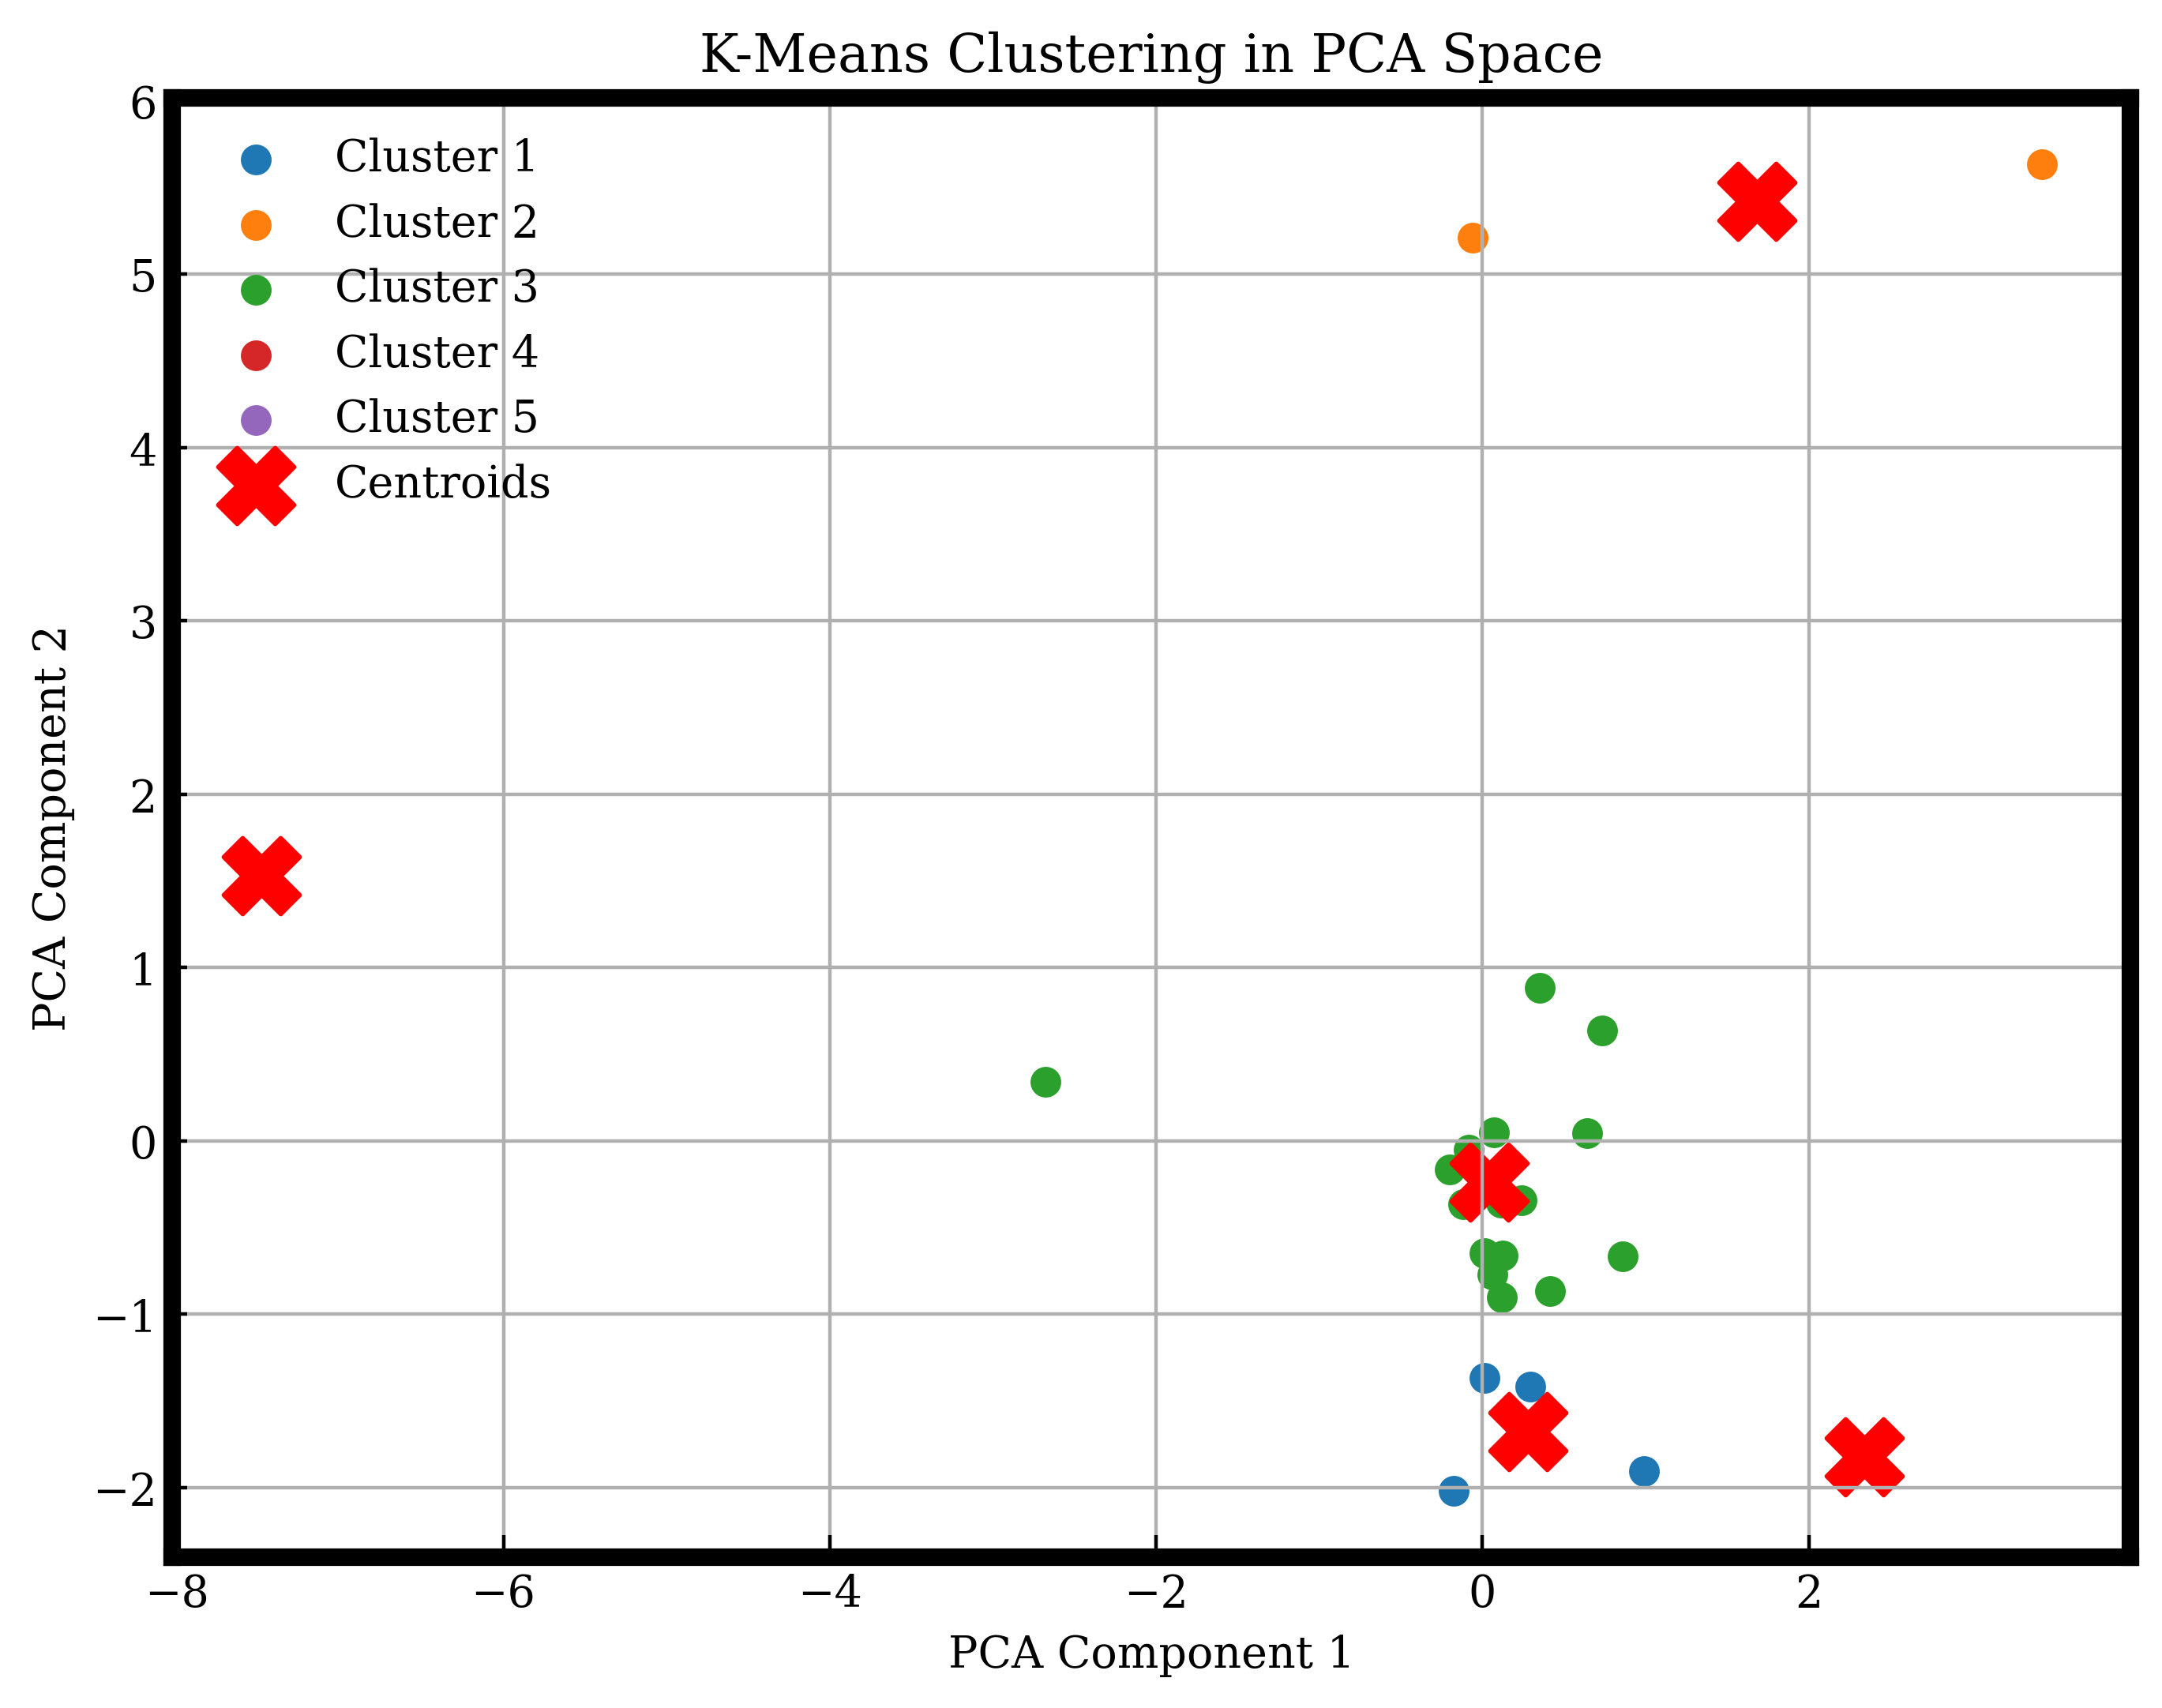

In [31]:
# Perform PCA to reduce dimensionality to 2 for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

# Perform K-Means clustering on the PCA-transformed data
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(pca_data)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Create a DataFrame for visualization
df = pd.DataFrame(pca_data, columns=['PCA_Component_1', 'PCA_Component_2'])
df['Cluster'] = labels
df['label'] = label

# Print cluster assignments along with labels
print(df[['Cluster', 'label']])

# Plotting the clusters in PCA space
plt.figure(figsize=(8, 6))
for cluster in range(num_clusters):
    plt.scatter(df[df['Cluster'] == cluster]['PCA_Component_1'],
                df[df['Cluster'] == cluster]['PCA_Component_2'],
                label=f'Cluster {cluster + 1}')

# Mark the centroids in the PCA space
plt.scatter((centers)[:, 0], centers[:, 1],s=300, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

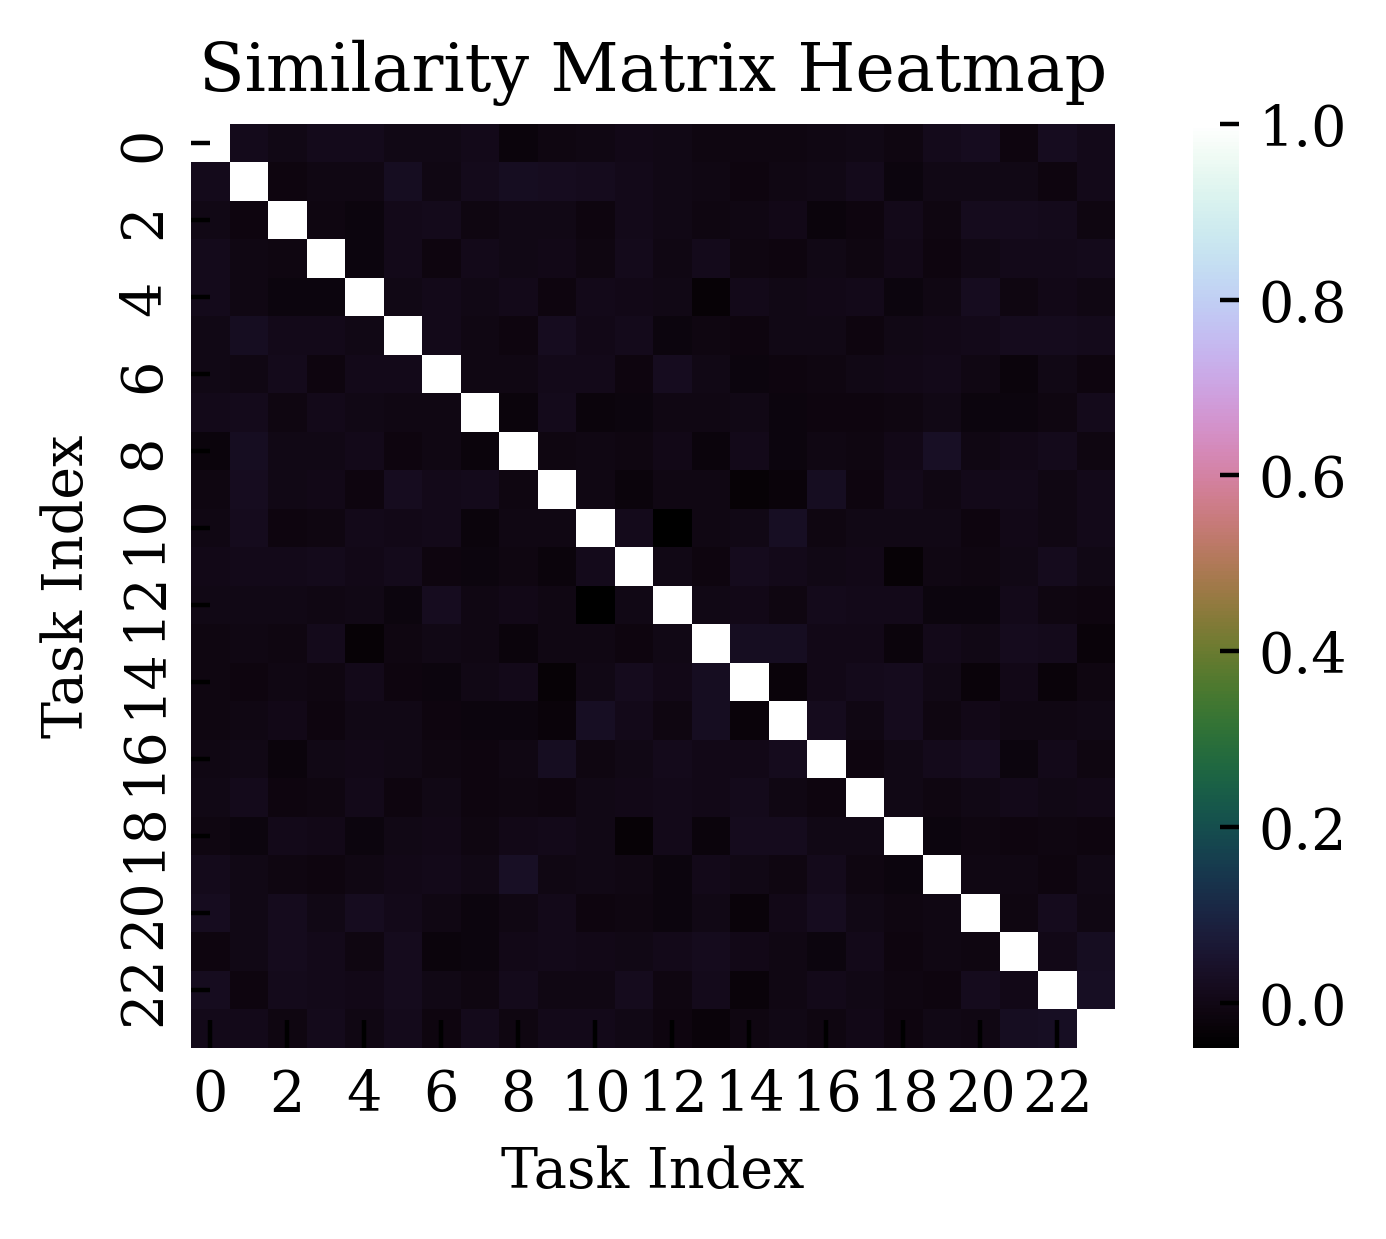

In [32]:
import seaborn as sns
# Plotting the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(similarity_matrix, annot=False, cmap='cubehelix', cbar=True, square=True)

plt.title('Similarity Matrix Heatmap')
plt.xlabel('Task Index')
plt.ylabel('Task Index')
plt.show()

In [33]:
np.round([0.3654,0.8976],2)

array([0.37, 0.9 ])

In [34]:
#test_label[:, i][~np.isnan(test_label[:, i])]

In [35]:
print(np.max((improved_tasks)))
np.where(improved_tasks==15)

13.0


(array([], dtype=int64),)

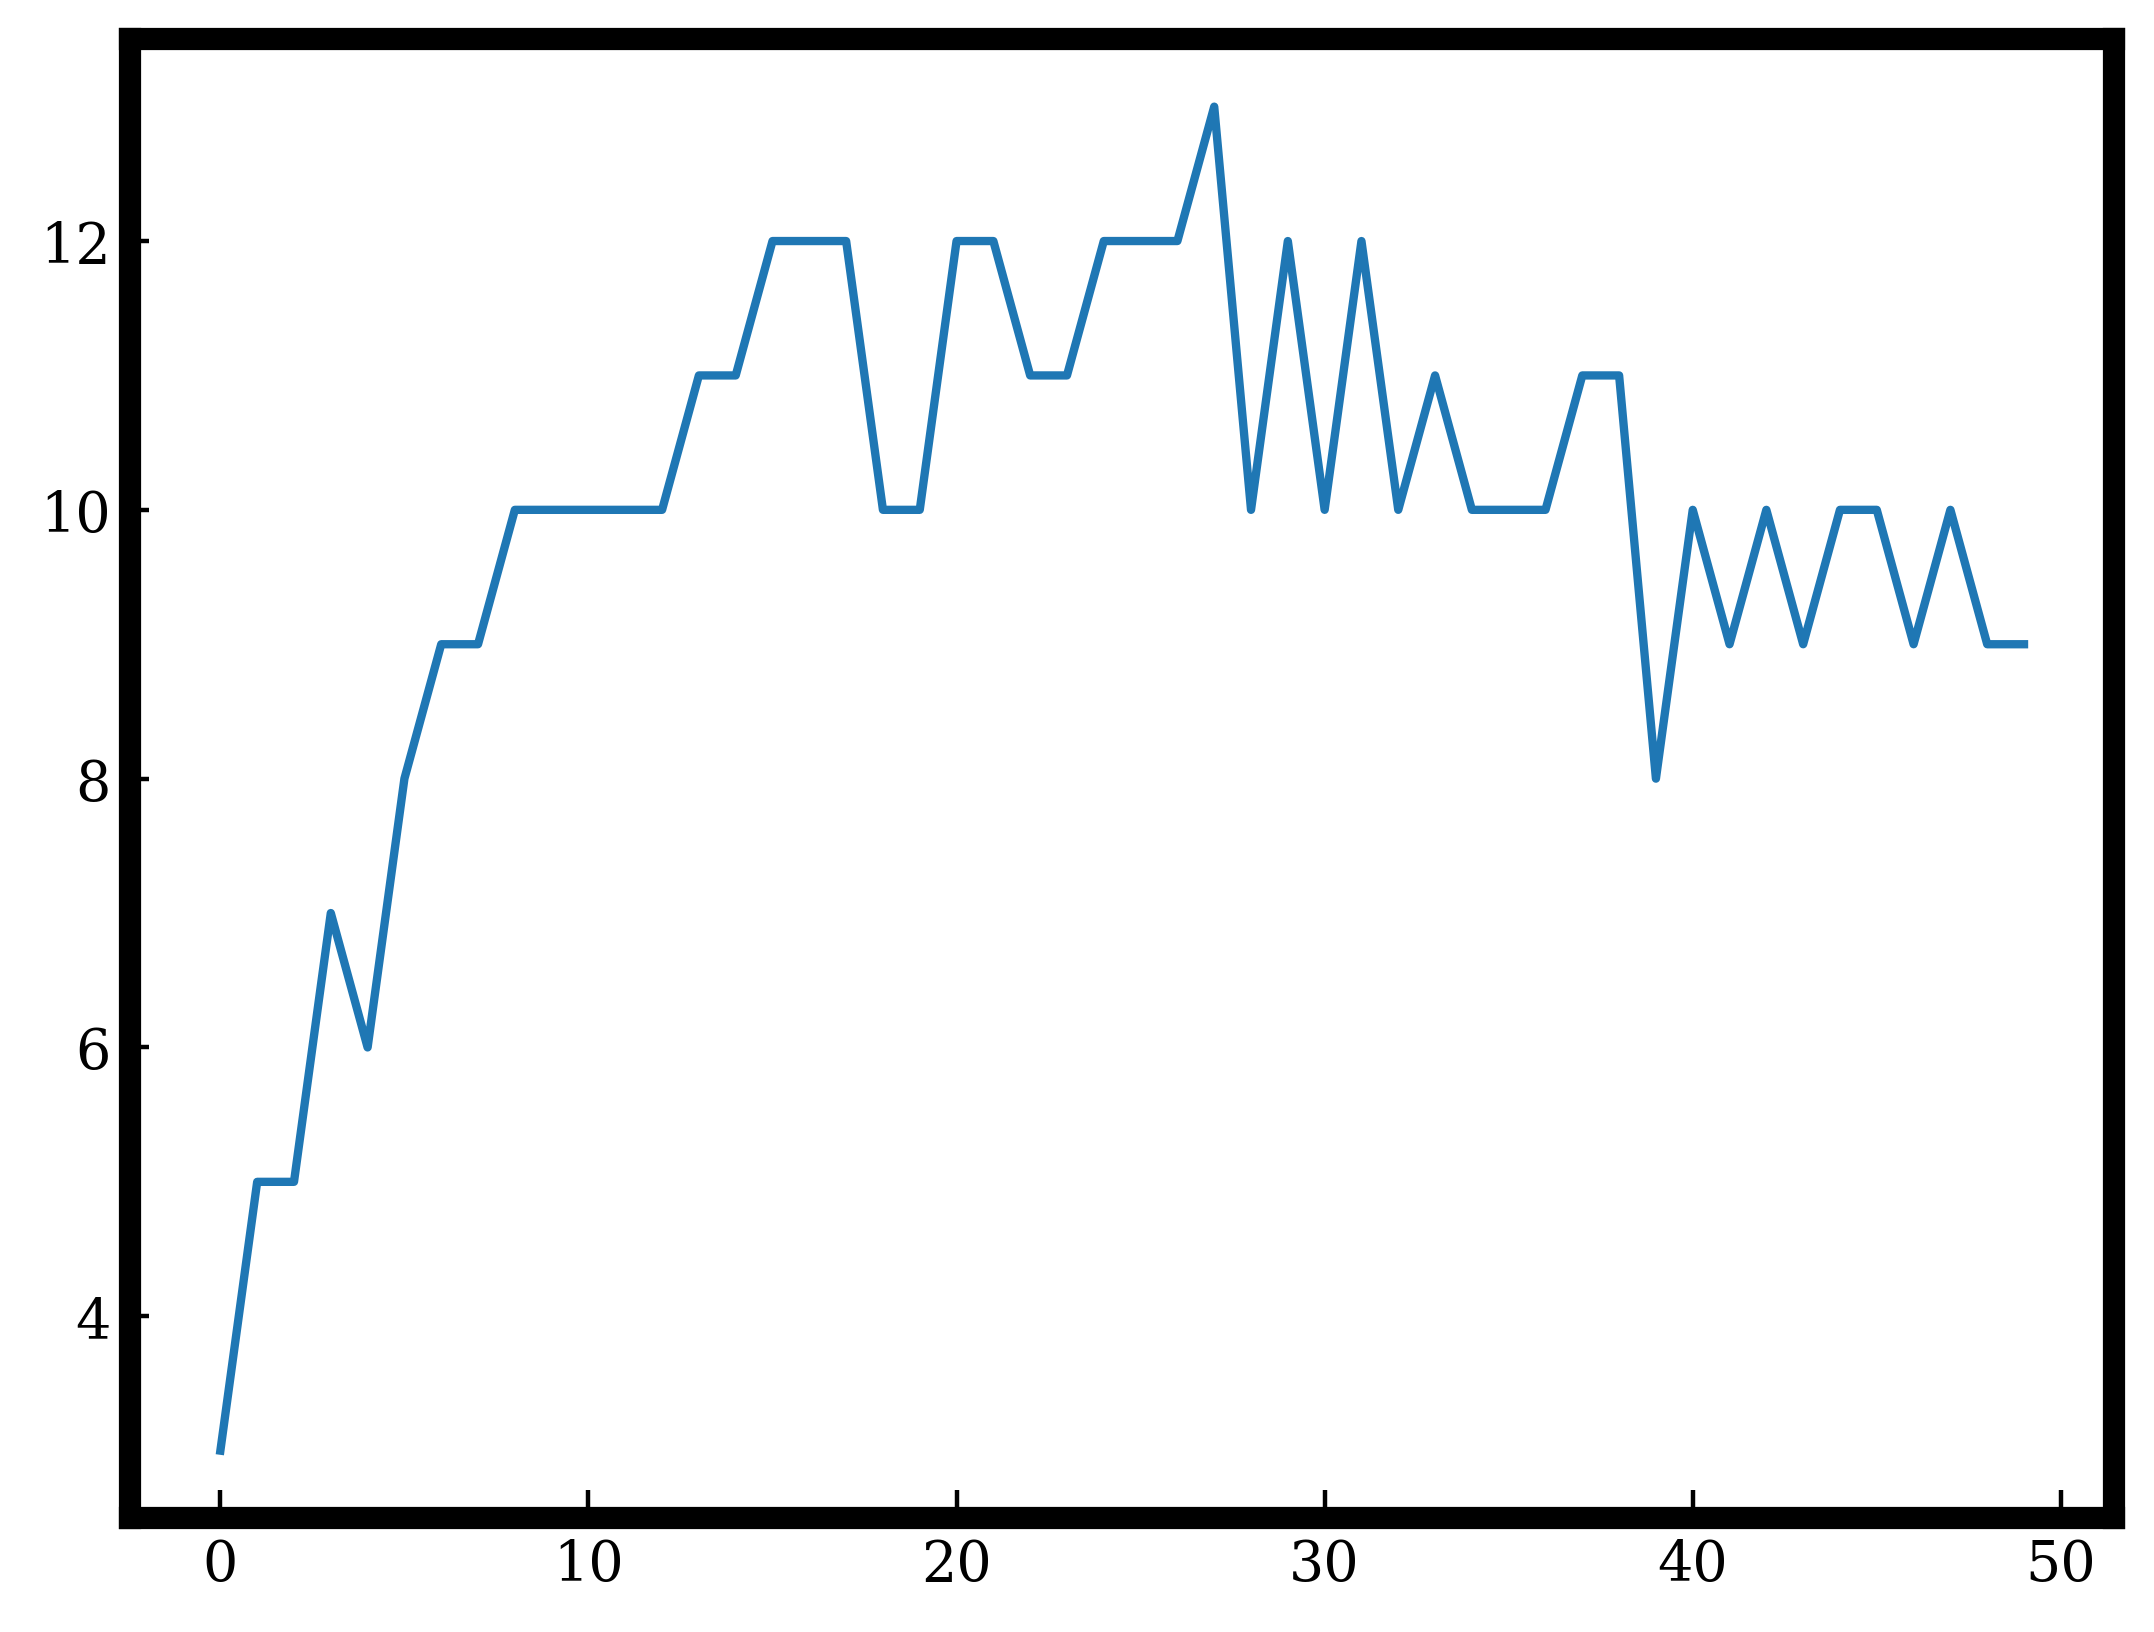

In [36]:
plt.plot(improved_tasks[:55])

In [37]:
#test_predictions = model.forward(torch.Tensor(test_data))

In [45]:
import torch
import joblib
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,roc_auc_score
# Load the scaler from the file
#scaler = m
def make_predictions(model, val_data):
    """
    Make predictions using a pretrained model on the provided validation data.

    Args:
    - model (torch.nn.Module): The pretrained model.
    - val_data (torch.Tensor): The validation data for making predictions.

    Returns:
    - predicted_classes_np (numpy.ndarray): The predicted classes as a numpy array.
    """
    # No gradient computation needed for inference
    with torch.no_grad():
        # Get the model's predictions for the validation data
        predictions = model.forward(val_data)
    predictions = [list(item) for item in zip(*predictions.values())]

    return np.array(predictions)

In [46]:
def Ticker(ax):
    """
    Styles the matplotlib axis..

    """
    from matplotlib.ticker import AutoMinorLocator
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    return ax
#plt.style.use("/home/suman/Dibyendu/DM_Projects/Project_SERB/NoteBooks/style.txt")
plt.rcParams['font.family'] = 'C059'

In [47]:
import matplotlib.patheffects as pe
def plot(train_pred,train_label,val_pred, val_label,test_pred,test_label,feature):
    pred0 = train_pred[~np.isnan(train_label)]
    actual0 = train_label[~np.isnan(train_label)]
    pred_val0 = val_pred[~np.isnan(val_label)]
    actual_val0 = val_label[~np.isnan(val_label)]
    pred_test0 = test_pred[~np.isnan(test_label)]
    actual_test0 = test_label[~np.isnan(test_label)]

    ##### Whole dataset plotted
    r2_val0 = r2_score(list(actual0) +list(actual_val0)+list(actual_test0), list(pred0)+list(pred_val0)+list(pred_test0))
    mae0 = mean_absolute_error(list(actual0) +list(actual_val0)+list(actual_test0), list(pred0)+list(pred_val0)+list(pred_test0))
    rmse = np.sqrt(mean_squared_error(list(actual0) +list(actual_val0)+list(actual_test0), list(pred0)+list(pred_val0)+list(pred_test0)))
    print(r2_val0)
    fig, ax = plt.subplots(figsize = (8, 5), dpi = 600)
    plt.scatter(np.array(actual0),np.array(pred0), c = "royalblue", edgecolor = "blue",label="training")
    plt.scatter(np.array(actual_val0),np.array(pred_val0), c = "lavender", edgecolor = "purple",label = "validation")
    plt.scatter(np.array(actual_test0),np.array(pred_test0), c = "coral", edgecolor = "maroon",label = "testing")
    plt.plot(plt.gca().get_xlim(),plt.gca().get_xlim(), lw = 1, ls = "--", c = "black", dashes=(6, 2),path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()])
    #plt.plot(np.linspace(-34, 7, 100), np.linspace(-34, 7, 100), lw = 1, ls = "--", c = "#ffa62b", dashes=(6, 2),
            #path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()])

    plt.text(x = 0, y = 1.02,transform=plt.gca().transAxes, s = f"$R^2 = {np.round(r2_val0,3)} ,$" , fontsize = 12)
    plt.text(x = 0.3, y = 1.02,transform=plt.gca().transAxes, s = f"$MAE = {np.round(mae0,3)} ,$", fontsize = 12)
    plt.text(x = 0.6, y = 1.02,transform=plt.gca().transAxes, s = f"$RMSE = {np.round(rmse,3)}$", fontsize = 12)
    plt.xlabel(f"Actual {feature}", fontsize = 16)
    plt.ylabel(f"Predicted {feature}", fontsize = 16)
    plt.legend(loc='upper left')
    Ticker(ax)
    fig.tight_layout()
    return  r2_val0, mae0 ,rmse

In [53]:
import matplotlib.patheffects as pe
def plot_test(train_pred,train_label,val_pred, val_label,feature,benchmark):
    pred_test0 = val_pred[~np.isnan(val_label)]
    actual_test0 = val_label[~np.isnan(val_label)]
    ##### Whole dataset plotted
    r2_val0 = r2_score(list(actual_test0), list(pred_test0))
    mae0 = mean_absolute_error(list(actual_test0), list(pred_test0))
    rmse = np.sqrt(mean_squared_error(list(actual_test0), list(pred_test0)))
    print(r2_val0,benchmark)
    fig, ax = plt.subplots(figsize = (8, 5))
    #plt.scatter(np.array(actual0),np.array(pred0), c = "royalblue", edgecolor = "blue",label="training")
    plt.scatter(np.array(actual_test0),np.array(pred_test0), c = "coral", edgecolor = "maroon",label = "testing")
    plt.plot(plt.gca().get_xlim(),plt.gca().get_xlim(), lw = 1, ls = "--", c = "black", dashes=(6, 2),path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()])
    #plt.plot(np.linspace(-34, 7, 100), np.linspace(-34, 7, 100), lw = 1, ls = "--", c = "#ffa62b", dashes=(6, 2),
            #path_effects=[pe.Stroke(linewidth=1.5, foreground='k'), pe.Normal()])

    plt.text(x = 0, y = 1.02,transform=plt.gca().transAxes, s = f"$R^2 = {np.round(r2_val0,3)} ,$" , fontsize = 12)
    plt.text(x = 0.3, y = 1.02,transform=plt.gca().transAxes, s = f"$MAE = {np.round(mae0,3)} ,$", fontsize = 12)
    plt.text(x = 0.6, y = 1.02,transform=plt.gca().transAxes, s = f"$RMSE = {np.round(rmse,3)}$", fontsize = 12)
    plt.xlabel(f"Actual {feature}", fontsize = 16)
    plt.ylabel(f"Predicted {feature}", fontsize = 16)
    plt.legend(loc='upper left')
    Ticker(ax)
    fig.tight_layout()
    return  r2_val0, mae0 ,rmse

In [54]:
label = ['HIA', 'OB', 'p-gp inhibitor', 'p-gp substrates', 'BBB',
       'Respiratory toxicity', 'Hepatotoxicity', 'half-life', 'CL',
       'Cardiotoxicity1', 'Cardiotoxicity10', 'Cardiotoxicity30',
       'Cardiotoxicity5', 'CYP1A2', 'CYP2C19', 'CYP2C9', 'CYP2D6', 'CYP3A4',
       'Acute oral toxicity (LD50)', 'IGC50', 'ESOL', 'logD',
       'Caco-2 permeability', 'PPB']
binary = [True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False]
benchmark = [0.981,0.749,0.928,0.801,0.973,0.859,0.701,0.727,0.779,0.740,0.654,0.723,0.641,0.95,0.804,0.794,0.869,0.916,0.635,0.819,0.931,0.915,0.523,0.626]

print(len(label),len(binary),len(benchmark))

24 24 24


In [55]:
# make predictions:
training_label = train_label
validation_label = val_label
testing_label = test_label

training_predictions = make_predictions(model, torch.Tensor(train_data))
training_predictions[:,-6:] = m.inverse_transform(training_predictions[:,-6:])
validation_predictions = make_predictions(model,torch.Tensor(val_data))
validation_predictions[:,-6:] = m.inverse_transform(validation_predictions[:,-6:])
test_predictions = make_predictions(model,torch.Tensor(test_data))
test_predictions[:,-6:] = m.inverse_transform(test_predictions[:,-6:])

training_label[:,-6:] = m.inverse_transform(train_label[:,-6:])
validation_label[:,-6:] = m.inverse_transform(val_label[:,-6:])
testing_label[:,-6:] = m.inverse_transform(test_label[:,-6:])

In [56]:
from sklearn.metrics import roc_auc_score
import numpy as np

def evaluate_model(test_predictions, test_label, train_predictions, train_label, label, binary,benchmark):
    """
    Evaluate the model's performance for each task.

    Parameters:
    - test_predictions (np.ndarray): Predictions made by the model on the test set.
    - test_label (np.ndarray): True labels for the test set.
    - train_predictions (np.ndarray): Predictions made by the model on the training set.
    - train_label (np.ndarray): True labels for the training set.
    - label (list[str]): List of task names/labels.
    - binary (list[bool]): Indicates whether each task is binary classification or not.
    """
    print("my_model", "benchmark")
    for i in range(len(label)):
        if binary[i]:
            try:
                y_pred = test_predictions[:, i]
                y_true = test_label[:, i]
                valid_indices = ~np.isnan(y_true)

                # Calculate ROC AUC score for binary classification tasks
                auc_score = roc_auc_score(y_true[valid_indices], torch.sigmoid(torch.Tensor(y_pred[valid_indices])))
                #print(f"{label[i]}: ROC AUC = {np.round(auc_score, 3)}")
                #print(y_true[valid_indices],torch.Tensor(y_pred[valid_indices]))
                print(np.round(auc_score, 3),benchmark[i])

            except Exception as e:
                print(f"Error evaluating {label[i]}: {e}")
                continue
        else:
            # Call the plotting function for regression tasks
            plot_test(train_predictions[:, i], train_label[:, i], test_predictions[:, i], test_label[:, i], feature=label[i], benchmark = benchmark[i])

# Example usage
# evaluate_model(test_predictions, test_label, training_predictions, train_label, label, binary)


my_model benchmark
0.952 0.981
0.809 0.749
0.928 0.928
0.768 0.801
0.902 0.973
0.894 0.859
0.631 0.701
0.746 0.727
0.777 0.779
0.853 0.74
0.81 0.654
0.79 0.723
0.849 0.641
0.944 0.95
0.911 0.804
0.916 0.794
0.852 0.869
0.932 0.916
-7.292502533792547 0.635
-8.89507442609872 0.819
-2.039988468686254 0.931
-0.6567688226453885 0.915
-0.29923936091984116 0.523
-3.2510464893243487 0.626


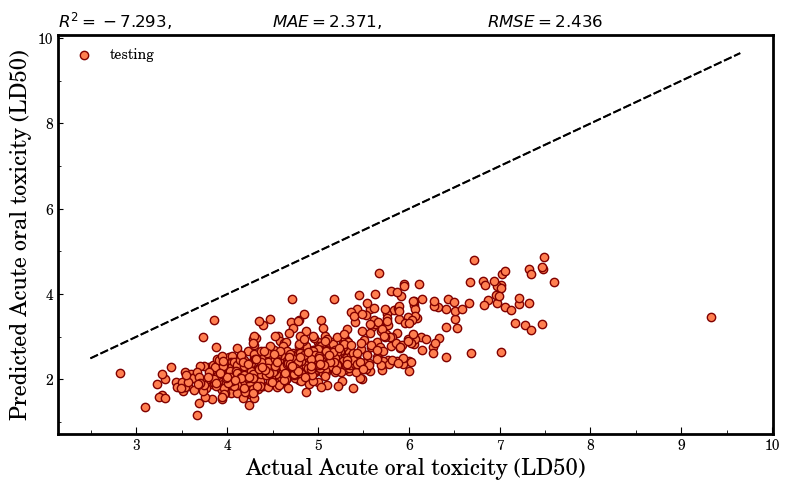

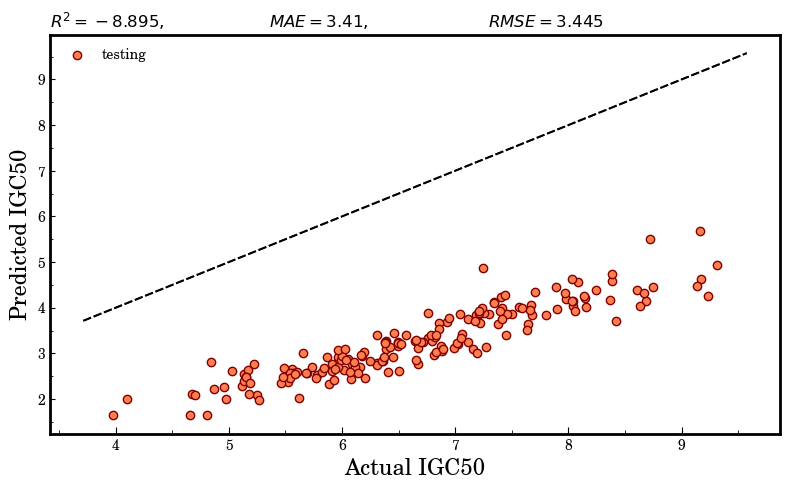

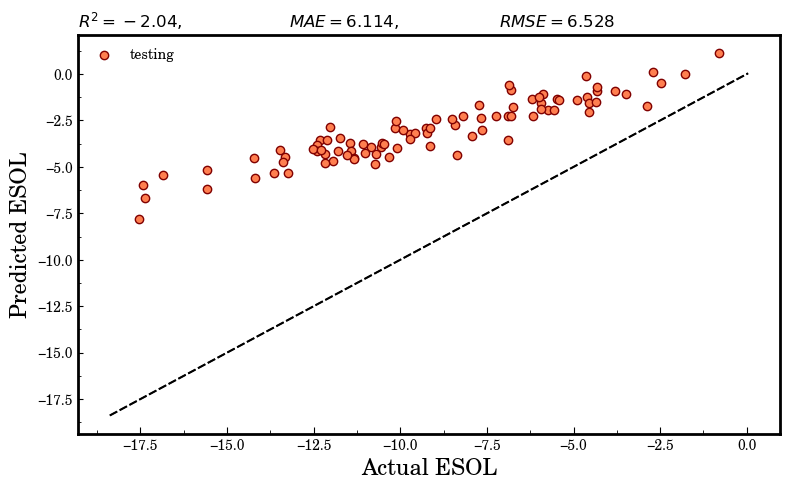

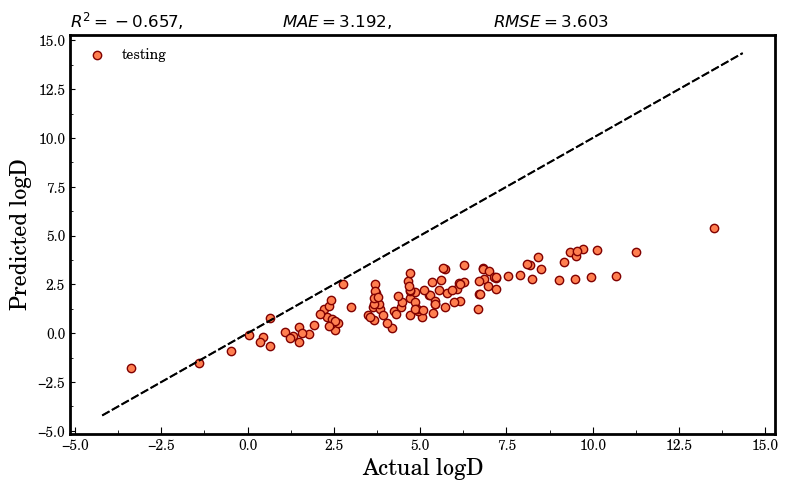

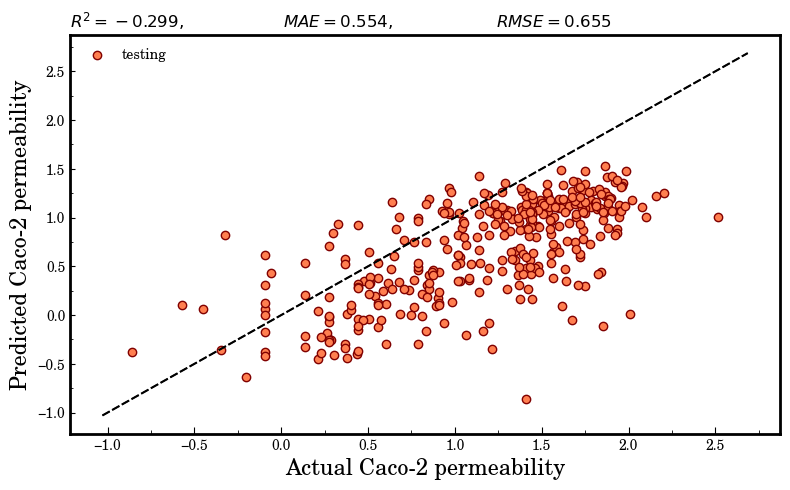

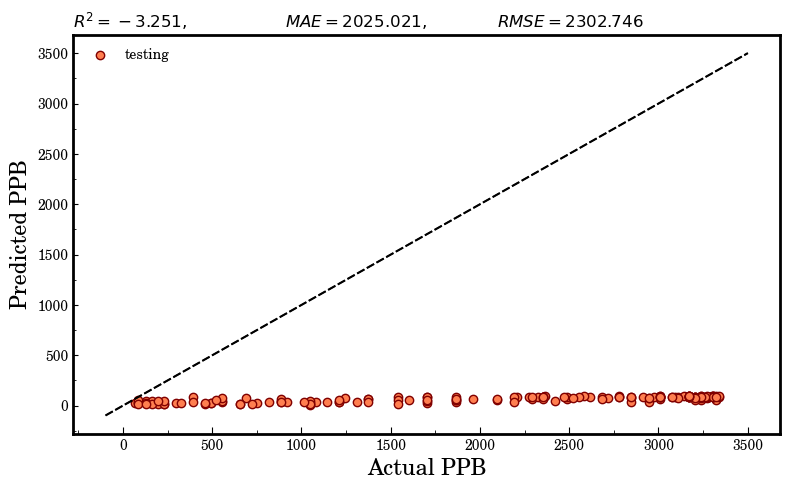

In [57]:
# Corrected function call
evaluate_model(
    test_predictions=test_predictions,
    test_label=testing_label,
    train_predictions=training_predictions,
    train_label=training_label,
    label=label,
    binary=binary,
    benchmark = benchmark
)


In [58]:
import numpy as np

# the array
array = np.array([0.748,0.731,0.669,0.728,0.643,0.748,0.713,0.735,0.660,0.773])

# Calculate mean and standard deviation
mean = np.mean(array)
std_dev = np.std(array)

# Display the results
print(f"Mean of the array: {np.round(mean,3)}")
print(f"Standard deviation of the array: {np.round(std_dev,3)}")


Mean of the array: 0.715
Standard deviation of the array: 0.041


In [59]:
print(model.task_layers[1][0])

Linear(in_features=128, out_features=64, bias=True)
